# NYC Taxi Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load data
Let's check the data files! According the data description we should find the following columns:
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the training set.

In [2]:
print('Loading training and test sets...')
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
print('Training set has {} observations and {} features.'.format(train_df.shape[0], train_df.shape[1] - 1))
print('Test set has {} observations and {} features.'.format(test_df.shape[0], test_df.shape[1]))

Loading training and test sets...
Training set has 1458644 observations and 10 features.
Test set has 625134 observations and 9 features.


In [3]:
train_df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [4]:
test_df.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
# Trip duration is highly skewed, will create a new log-transformed variable
train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)

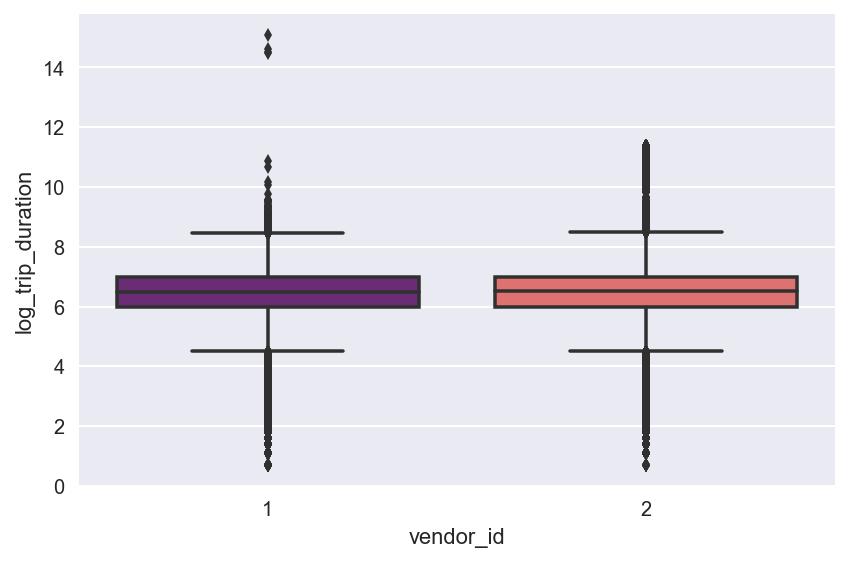

In [7]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='vendor_id', y='log_trip_duration', data=train_df, palette='magma')
plt.tight_layout()

In [8]:
# Some trip durations are absurdly high, some forgot the meter running...
# They are all from vendor 1
train_df[train_df.trip_duration > 100000]

id  vendor_id      pickup_datetime     dropoff_datetime  \
355003  id1864733          1  2016-01-05 00:19:42  2016-01-27 11:08:38   
680594  id0369307          1  2016-02-13 22:38:00  2016-03-08 15:57:38   
924150  id1325766          1  2016-01-05 06:14:15  2016-01-31 01:01:07   
978383  id0053347          1  2016-02-13 22:46:52  2016-03-25 18:18:14   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
355003                1        -73.789650        40.643559         -73.956810   
680594                2        -73.921677        40.735252         -73.984749   
924150                1        -73.983788        40.742325         -73.985489   
978383                1        -73.783905        40.648632         -73.978271   

        dropoff_latitude store_and_fwd_flag  trip_duration  log_trip_duration  
355003         40.773087                  N        1939736          14.478063  
680594         40.759979                  N        2049578          14.533145  
924150         40.727676                  N        2227612          14.616441  
978383         40.750202                  N        3526282          15.075755

In [9]:
# And there are 1957 above 60000 and all for vendor 2! Will attempt to remove these ones as well...
train_df[train_df.trip_duration > 80000].vendor_id.value_counts()

2    1957
1       4
Name: vendor_id, dtype: int64

In [10]:
# We can consider removing these four outliers
train_df = train_df[train_df.trip_duration < 60000]

In [ ]:
# There are 1984 instances with trip duration below 10s. Let's remove these outliers.
train_df = train_df[train_df.trip_duration >= 10]

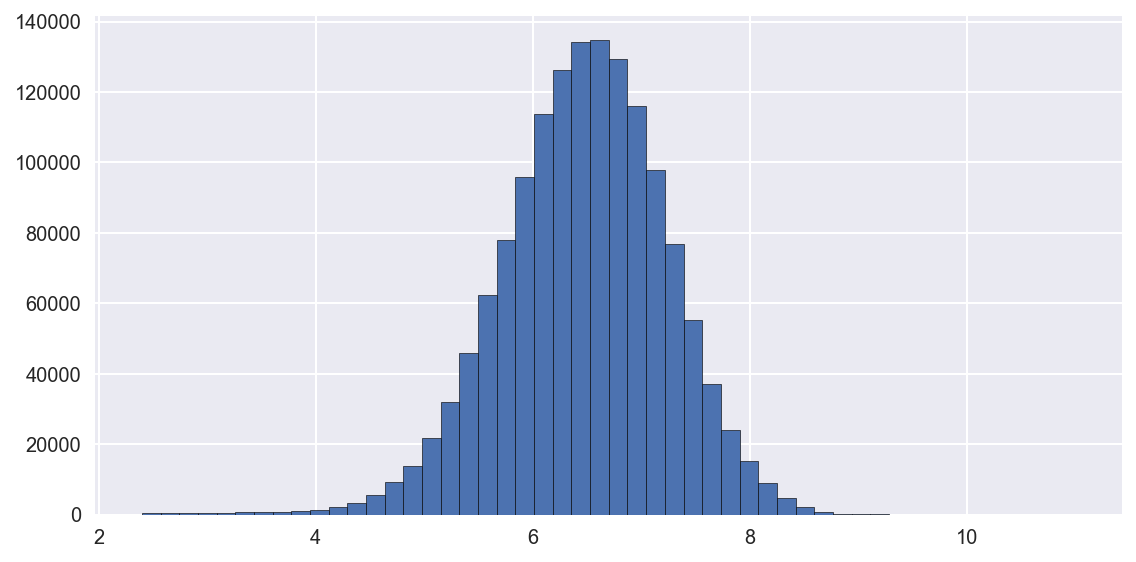

In [12]:
plt.figure(figsize=(8, 4))
train_df.log_trip_duration.hist(bins=50)
plt.tight_layout()

In [13]:
train_df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.454699e+06     1.454699e+06      1.454699e+06     1.454699e+06   
mean   1.534592e+00     1.664537e+00     -7.397354e+01     4.075095e+01   
std    4.988021e-01     1.314048e+00      7.087533e-02     3.282573e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073738e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075412e+01   
75%    2.000000e+00     2.000000e+00     -7.396736e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  log_trip_duration  
count       1.454699e+06      1.454699e+06   1.454699e+06       1.454699e+06  
mean       -7.397347e+01      4.075183e+01   8.409608e+02       6.466795e+00  
std         7.061543e-02      3.583750e-02   7.370245e+02       7.565394e-01  
min        -1.219333e+02      3.218114e+01   1.000000e+01       2.397895e+00  
25%        -7.399133e+01      4.073592e+01   3.980000e+02       5.988961e+00  
50%        -7.397976e+01      4.075454e+01   6.620000e+02       6.496775e+00  
75%        -7.396304e+01      4.076982e+01   1.074000e+03       6.980076e+00  
max        -6.133553e+01      4.392103e+01   5.984900e+04       1.099960e+01

In [14]:
train_df.groupby('vendor_id')['passenger_count', 'trip_duration'].mean()

passenger_count  trip_duration
vendor_id                                
1                 1.259852     832.677851
2                 2.016850     848.171830

In [15]:
train_df.groupby('passenger_count')['vendor_id', 'trip_duration'].mean()

vendor_id  trip_duration
passenger_count                          
0                 1.428571     487.942857
1                 1.466819     828.902537
2                 1.561146     881.679660
3                 1.616126     872.164324
4                 1.578717     890.257780
5                 1.995580     849.023550
6                 1.996846     841.116608
7                 2.000000      19.666667
8                 2.000000     104.000000
9                 2.000000     560.000000

In [16]:
train_df.groupby('store_and_fwd_flag')['vendor_id', 'passenger_count', 'trip_duration'].mean()

vendor_id  passenger_count  trip_duration
store_and_fwd_flag                                           
N                    1.537548         1.666658     839.600713
Y                    1.000000         1.281035    1086.948869

# Datetime

In [17]:
def date_unravel(datetime):
    df = pd.DataFrame(pd.to_datetime(datetime))
    
    name = datetime.name
#     df['ordinal_time'] = df[name].map(pd.datetime.toordinal)
#     df['quarter'] = df[name].dt.quarter
    df['month'] = df[name].dt.month
    df['week_of_year'] = df[name].dt.weekofyear
    df.week_of_year.replace({53: 0}, inplace=True)
    df['day_of_year'] = df[name].dt.dayofyear
    df['day_of_month'] = df[name].dt.day
    df['day_of_week'] = df[name].dt.dayofweek
    df['day_of_week_name'] = df[name].dt.weekday_name
    df['hour_of_day'] = df[name].dt.hour
    df['minute'] = df[name].dt.minute
    
    df['is_weekend'] = (df.day_of_week > 4)
    holidays = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15', '2016-05-30', '2016-07-04', 
                '2016-09-05', '2016-10-10', '2016-11-08', '2016-11-11', '2016-11-24', '2016-12-26']
    df['is_holiday'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') in holidays else False)
    school_holidays = ['2016-02-08', '2016-07-05', '2016-09-11', '2016-10-03', '2016-10-04', 
                       '2016-10-12']
    df['is_school_holiday'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') in school_holidays else False)
    df['is_superbowl'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') == '2016-02-07' else False)
    df['is_easter'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') == '2016-03-27' else False)
    df['is_valentines'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') == '2016-02-14' else False)
    df['is_mothers_day'] = df.pickup_datetime.map(
        lambda x: True if x.strftime('%Y-%m-%d') == '2016-05-08' else False)
    
    return df

In [18]:
%%time
train_time_df = pd.concat([train_df.drop(['pickup_datetime', 'dropoff_datetime'], axis=1),
                           date_unravel(train_df.pickup_datetime)],
                          axis = 1)
test_time_df = pd.concat([test_df.drop('pickup_datetime', axis=1),
                          date_unravel(test_df.pickup_datetime)],
                         axis=1)

CPU times: user 1min 48s, sys: 1.7 s, total: 1min 50s
Wall time: 1min 50s


In [19]:
train_time_df.head()

id  vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0  id2875421          2                1        -73.982155        40.767937   
1  id2377394          1                1        -73.980415        40.738564   
2  id3858529          2                1        -73.979027        40.763939   
3  id3504673          2                1        -74.010040        40.719971   
4  id2181028          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                  N            455   
1         -73.999481         40.731152                  N            663   
2         -74.005333         40.710087                  N           2124   
3         -74.012268         40.706718                  N            429   
4         -73.972923         40.782520                  N            435   

   log_trip_duration     pickup_datetime  month  week_of_year  day_of_year  \
0           6.122493 2016-03-14 17:24:55      3            11           74   
1           6.498282 2016-06-12 00:43:35      6            23          164   
2           7.661527 2016-01-19 11:35:24      1             3           19   
3           6.063785 2016-04-06 19:32:31      4            14           97   
4           6.077642 2016-03-26 13:30:55      3            12           86   

   day_of_month  day_of_week day_of_week_name  hour_of_day  minute  \
0            14            0           Monday           17      24   
1            12            6           Sunday            0      43   
2            19            1          Tuesday           11      35   
3             6            2        Wednesday           19      32   
4            26            5         Saturday           13      30   

   is_weekend  is_holiday  is_school_holiday  is_superbowl  is_easter  \
0       False       False              False         False      False   
1        True       False              False         False      False   
2       False       False              False         False      False   
3       False       False              False         False      False   
4        True       False              False         False      False   

   is_valentines  is_mothers_day  
0          False           False  
1          False           False  
2          False           False  
3          False           False  
4          False           False

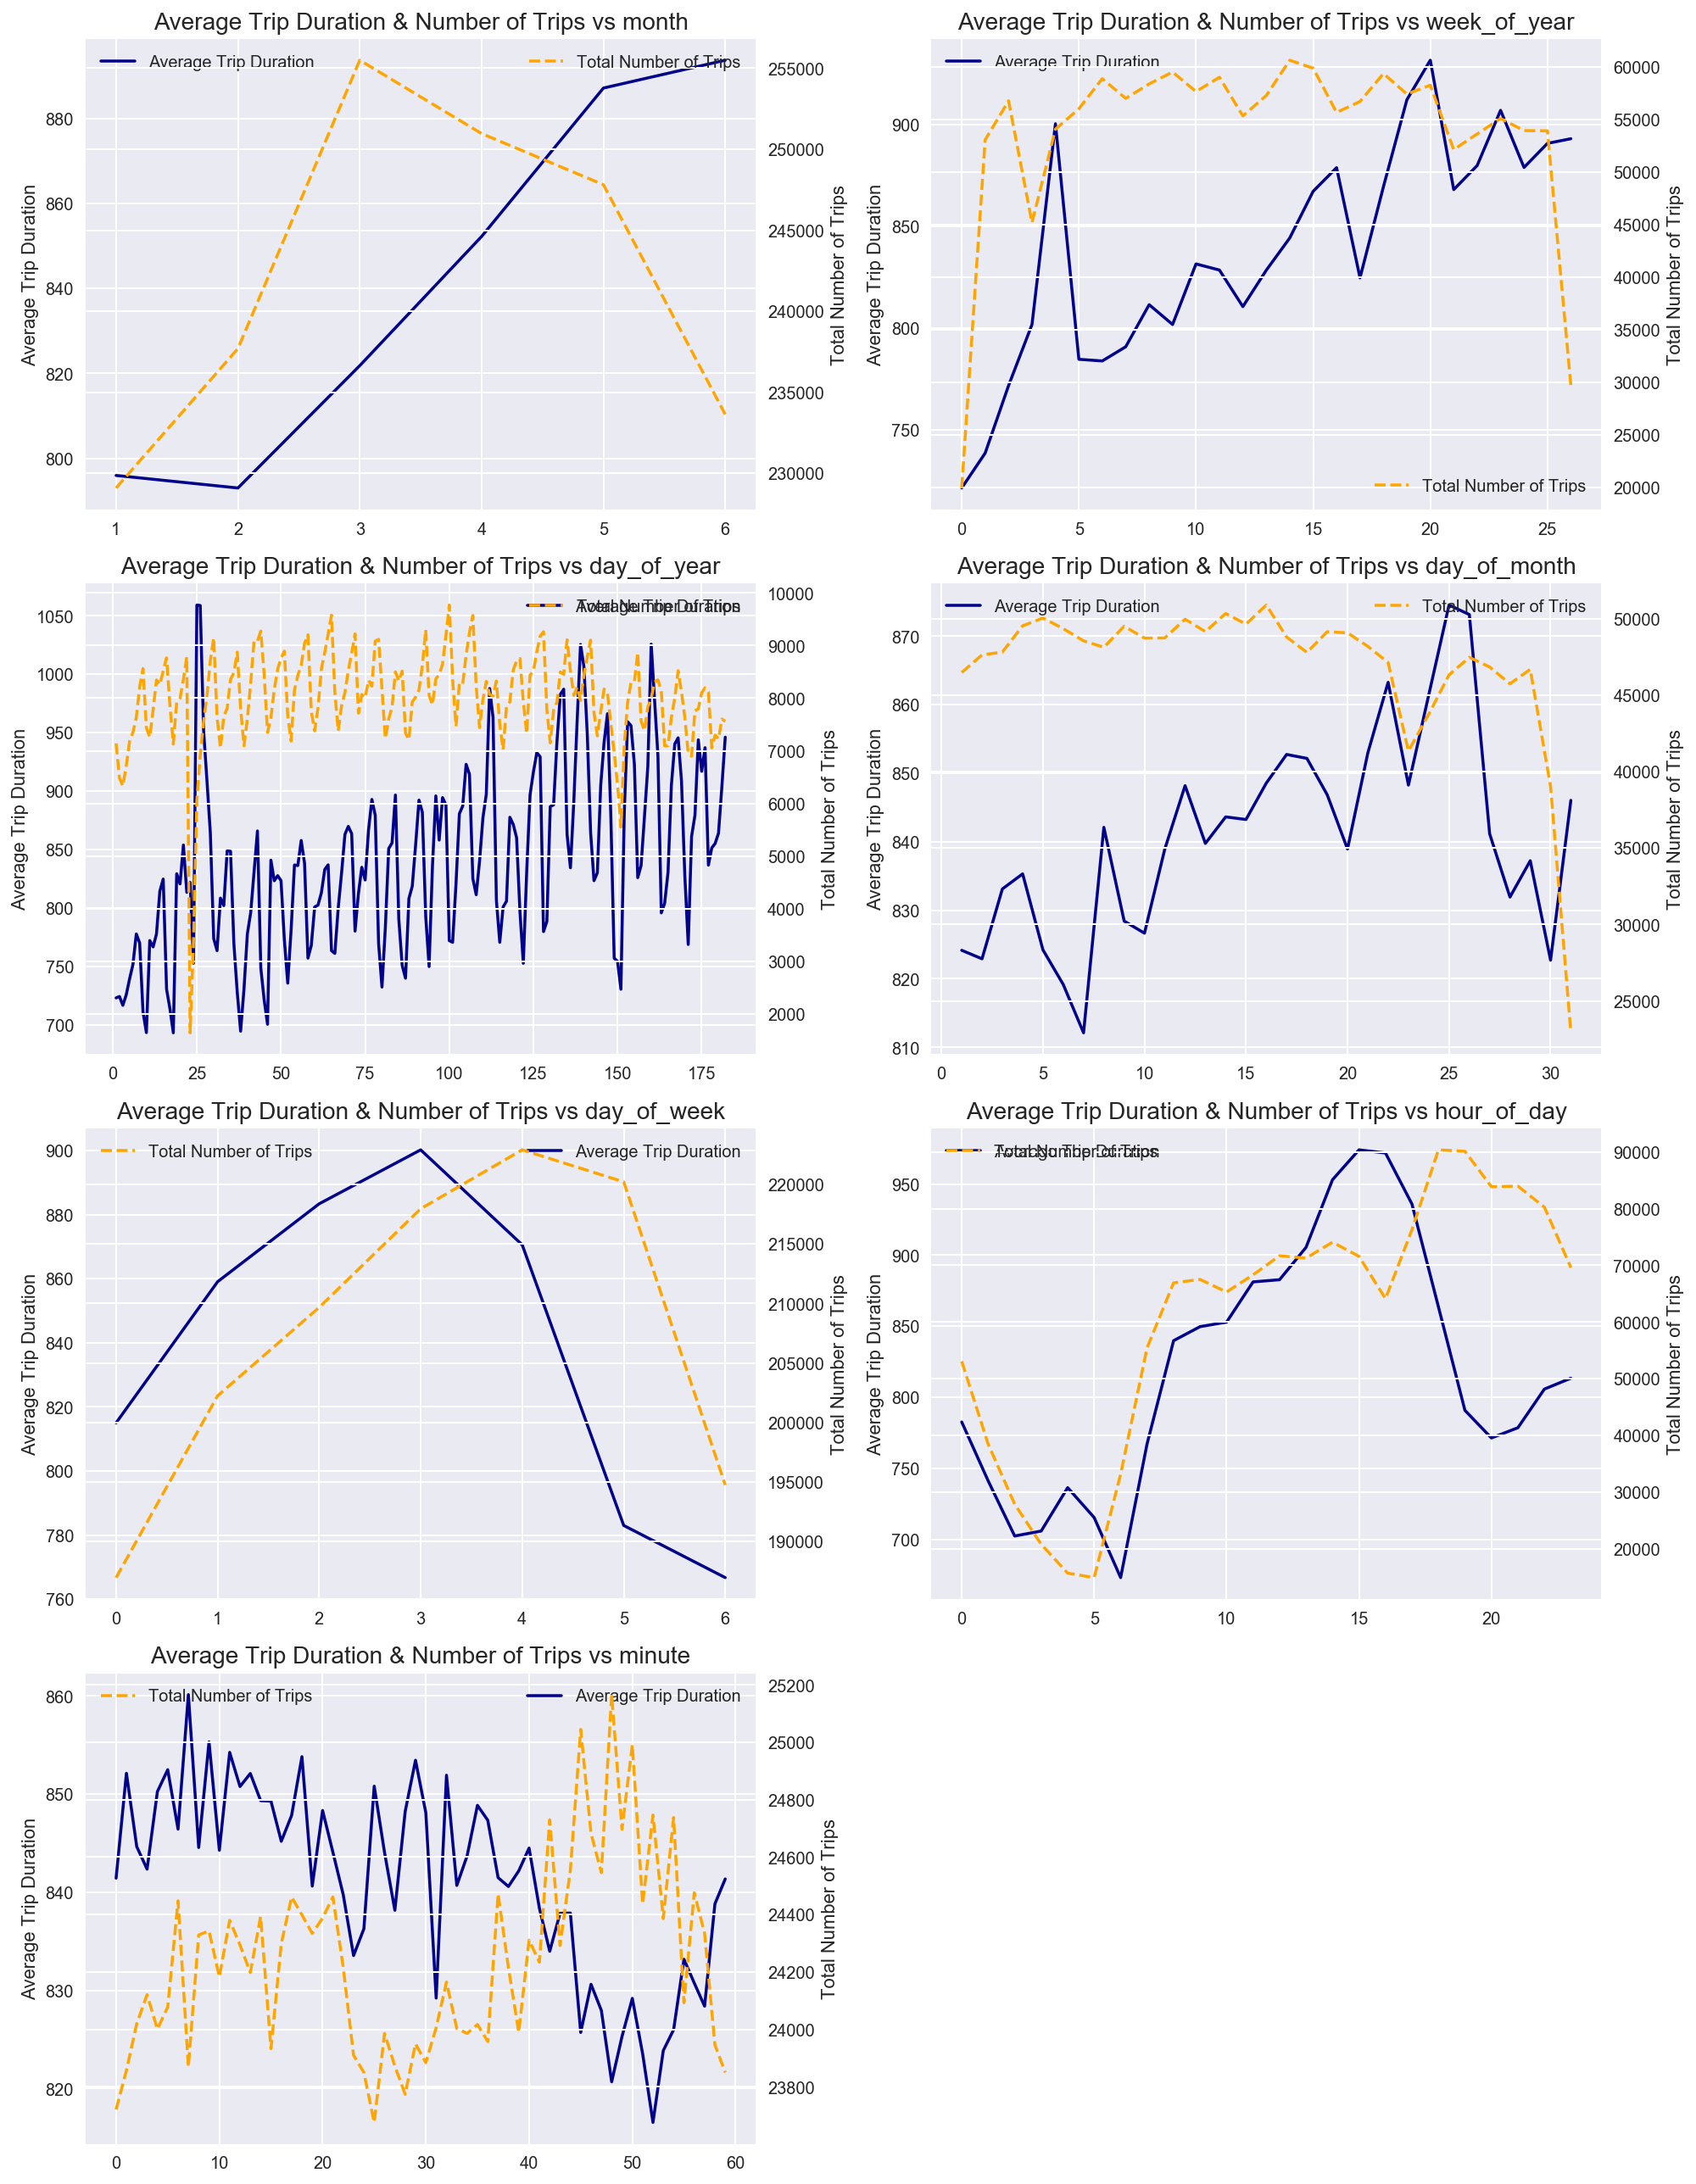

In [20]:
time_features = ['month', 'week_of_year', 'day_of_year', 'day_of_month',
                 'day_of_week', 'hour_of_day', 'minute']
plt.figure(figsize=(14, 18))
for i, feature in enumerate(time_features):
    ax1 = plt.subplot(4, 2, i+1)
    ax2 = ax1.twinx()
    ax1.plot(train_time_df.groupby(feature).trip_duration.mean(), c='darkblue')
    ax2.plot(train_time_df.groupby(feature).trip_duration.count(), c='orange', ls='dashed')
    plt.title('Average Trip Duration & Number of Trips vs {}'.format(feature), fontsize=14)
    ax1.set_ylabel('Average Trip Duration')
    ax2.set_ylabel('Total Number of Trips')
    ax1.legend(['Average Trip Duration'])
    ax2.legend(['Total Number of Trips'])
    plt.tight_layout()

# Distance

In [21]:
%%time
from sklearn.decomposition import PCA
coords = np.vstack((train_df[['pickup_latitude', 'pickup_longitude']].values,
                    train_df[['dropoff_latitude', 'dropoff_longitude']].values,
                    test_df[['pickup_latitude', 'pickup_longitude']].values,
                    test_df[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)

train_time_df['pickup_pc1'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:, 0]
train_time_df['pickup_pc2'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:, 1]
train_time_df['dropoff_pc1'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train_time_df['dropoff_pc2'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test_time_df['pickup_pc1'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:, 0]
test_time_df['pickup_pc2'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:, 1]
test_time_df['dropoff_pc1'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test_time_df['dropoff_pc2'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

CPU times: user 1.14 s, sys: 269 ms, total: 1.41 s
Wall time: 657 ms


In [22]:
import geopy.distance as geo
def vincenty_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    m = len(pickup_latitude)
    distance = np.zeros(m)
    location_1 = np.c_[pickup_latitude, pickup_longitude]
    location_2 = np.c_[dropoff_latitude, dropoff_longitude]
    for i in range(m):
        distance[i] = geo.vincenty(location_1[i, :], location_2[i, :]).km
    return distance

def manhattan_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    m = len(pickup_latitude)
    distance = np.zeros(m)
    location_1 = np.c_[pickup_latitude, pickup_longitude]
    location_2 = np.c_[pickup_latitude, dropoff_longitude]
    location_3 = np.c_[dropoff_latitude, pickup_longitude]
    for i in range(m):
        distance[i] = geo.vincenty(location_1[i, :], location_2[i, :]).km + \
        geo.vincenty(location_1[i, :], location_3[i, :]).km
    return distance

In [23]:
%%time
train_time_df['vincenty_distance'] = vincenty_distance(
    train_time_df.pickup_latitude.values,
    train_time_df.pickup_longitude.values,
    train_time_df.dropoff_latitude.values,
    train_time_df.dropoff_longitude.values
)
# train_time_df['log_vincenty_distance'] = np.log1p(train_time_df.vincenty_distance)
train_time_df['pca_vincenty_distance'] = vincenty_distance(
    train_time_df.pickup_pc1.values,
    train_time_df.pickup_pc2.values,
    train_time_df.dropoff_pc1.values,
    train_time_df.dropoff_pc2.values
)
# train_time_df['log_pca_vincenty_distance'] = np.log1p(train_time_df.pca_vincenty_distance)
train_time_df['manhattan_distance'] = manhattan_distance(
    train_time_df.pickup_latitude.values,
    train_time_df.pickup_longitude.values,
    train_time_df.dropoff_latitude.values,
    train_time_df.dropoff_longitude.values
)
# train_time_df['log_manhattan_distance'] = np.log1p(train_time_df.manhattan_distance)
train_time_df['pca_manhattan_distance'] = manhattan_distance(
    train_time_df.pickup_pc1.values,
    train_time_df.pickup_pc2.values,
    train_time_df.dropoff_pc1.values,
    train_time_df.dropoff_pc2.values
)
# train_time_df['log_pca_manhattan_distance'] = np.log1p(train_time_df.pca_manhattan_distance)

test_time_df['vincenty_distance'] = vincenty_distance(
    test_time_df.pickup_latitude.values,
    test_time_df.pickup_longitude.values,
    test_time_df.dropoff_latitude.values,
    test_time_df.dropoff_longitude.values
)
# test_time_df['log_vincenty_distance'] = np.log1p(test_time_df.vincenty_distance)
test_time_df['pca_vincenty_distance'] = vincenty_distance(
    test_time_df.pickup_pc1.values,
    test_time_df.pickup_pc2.values,
    test_time_df.dropoff_pc1.values,
    test_time_df.dropoff_pc2.values
)
# test_time_df['log_pca_vincenty_distance'] = np.log1p(test_time_df.pca_vincenty_distance)
test_time_df['manhattan_distance'] = manhattan_distance(
    test_time_df.pickup_latitude.values,
    test_time_df.pickup_longitude.values,
    test_time_df.dropoff_latitude.values,
    test_time_df.dropoff_longitude.values
)
# test_time_df['log_manhattan_distance'] = np.log1p(test_time_df.manhattan_distance)
test_time_df['pca_manhattan_distance'] = manhattan_distance(
    test_time_df.pickup_pc1.values,
    test_time_df.pickup_pc2.values,
    test_time_df.dropoff_pc1.values,
    test_time_df.dropoff_pc2.values
)
# test_time_df['log_pca_manhattan_distance'] = np.log1p(test_time_df.pca_manhattan_distance)

CPU times: user 5min 53s, sys: 542 ms, total: 5min 54s
Wall time: 5min 54s


# Speed

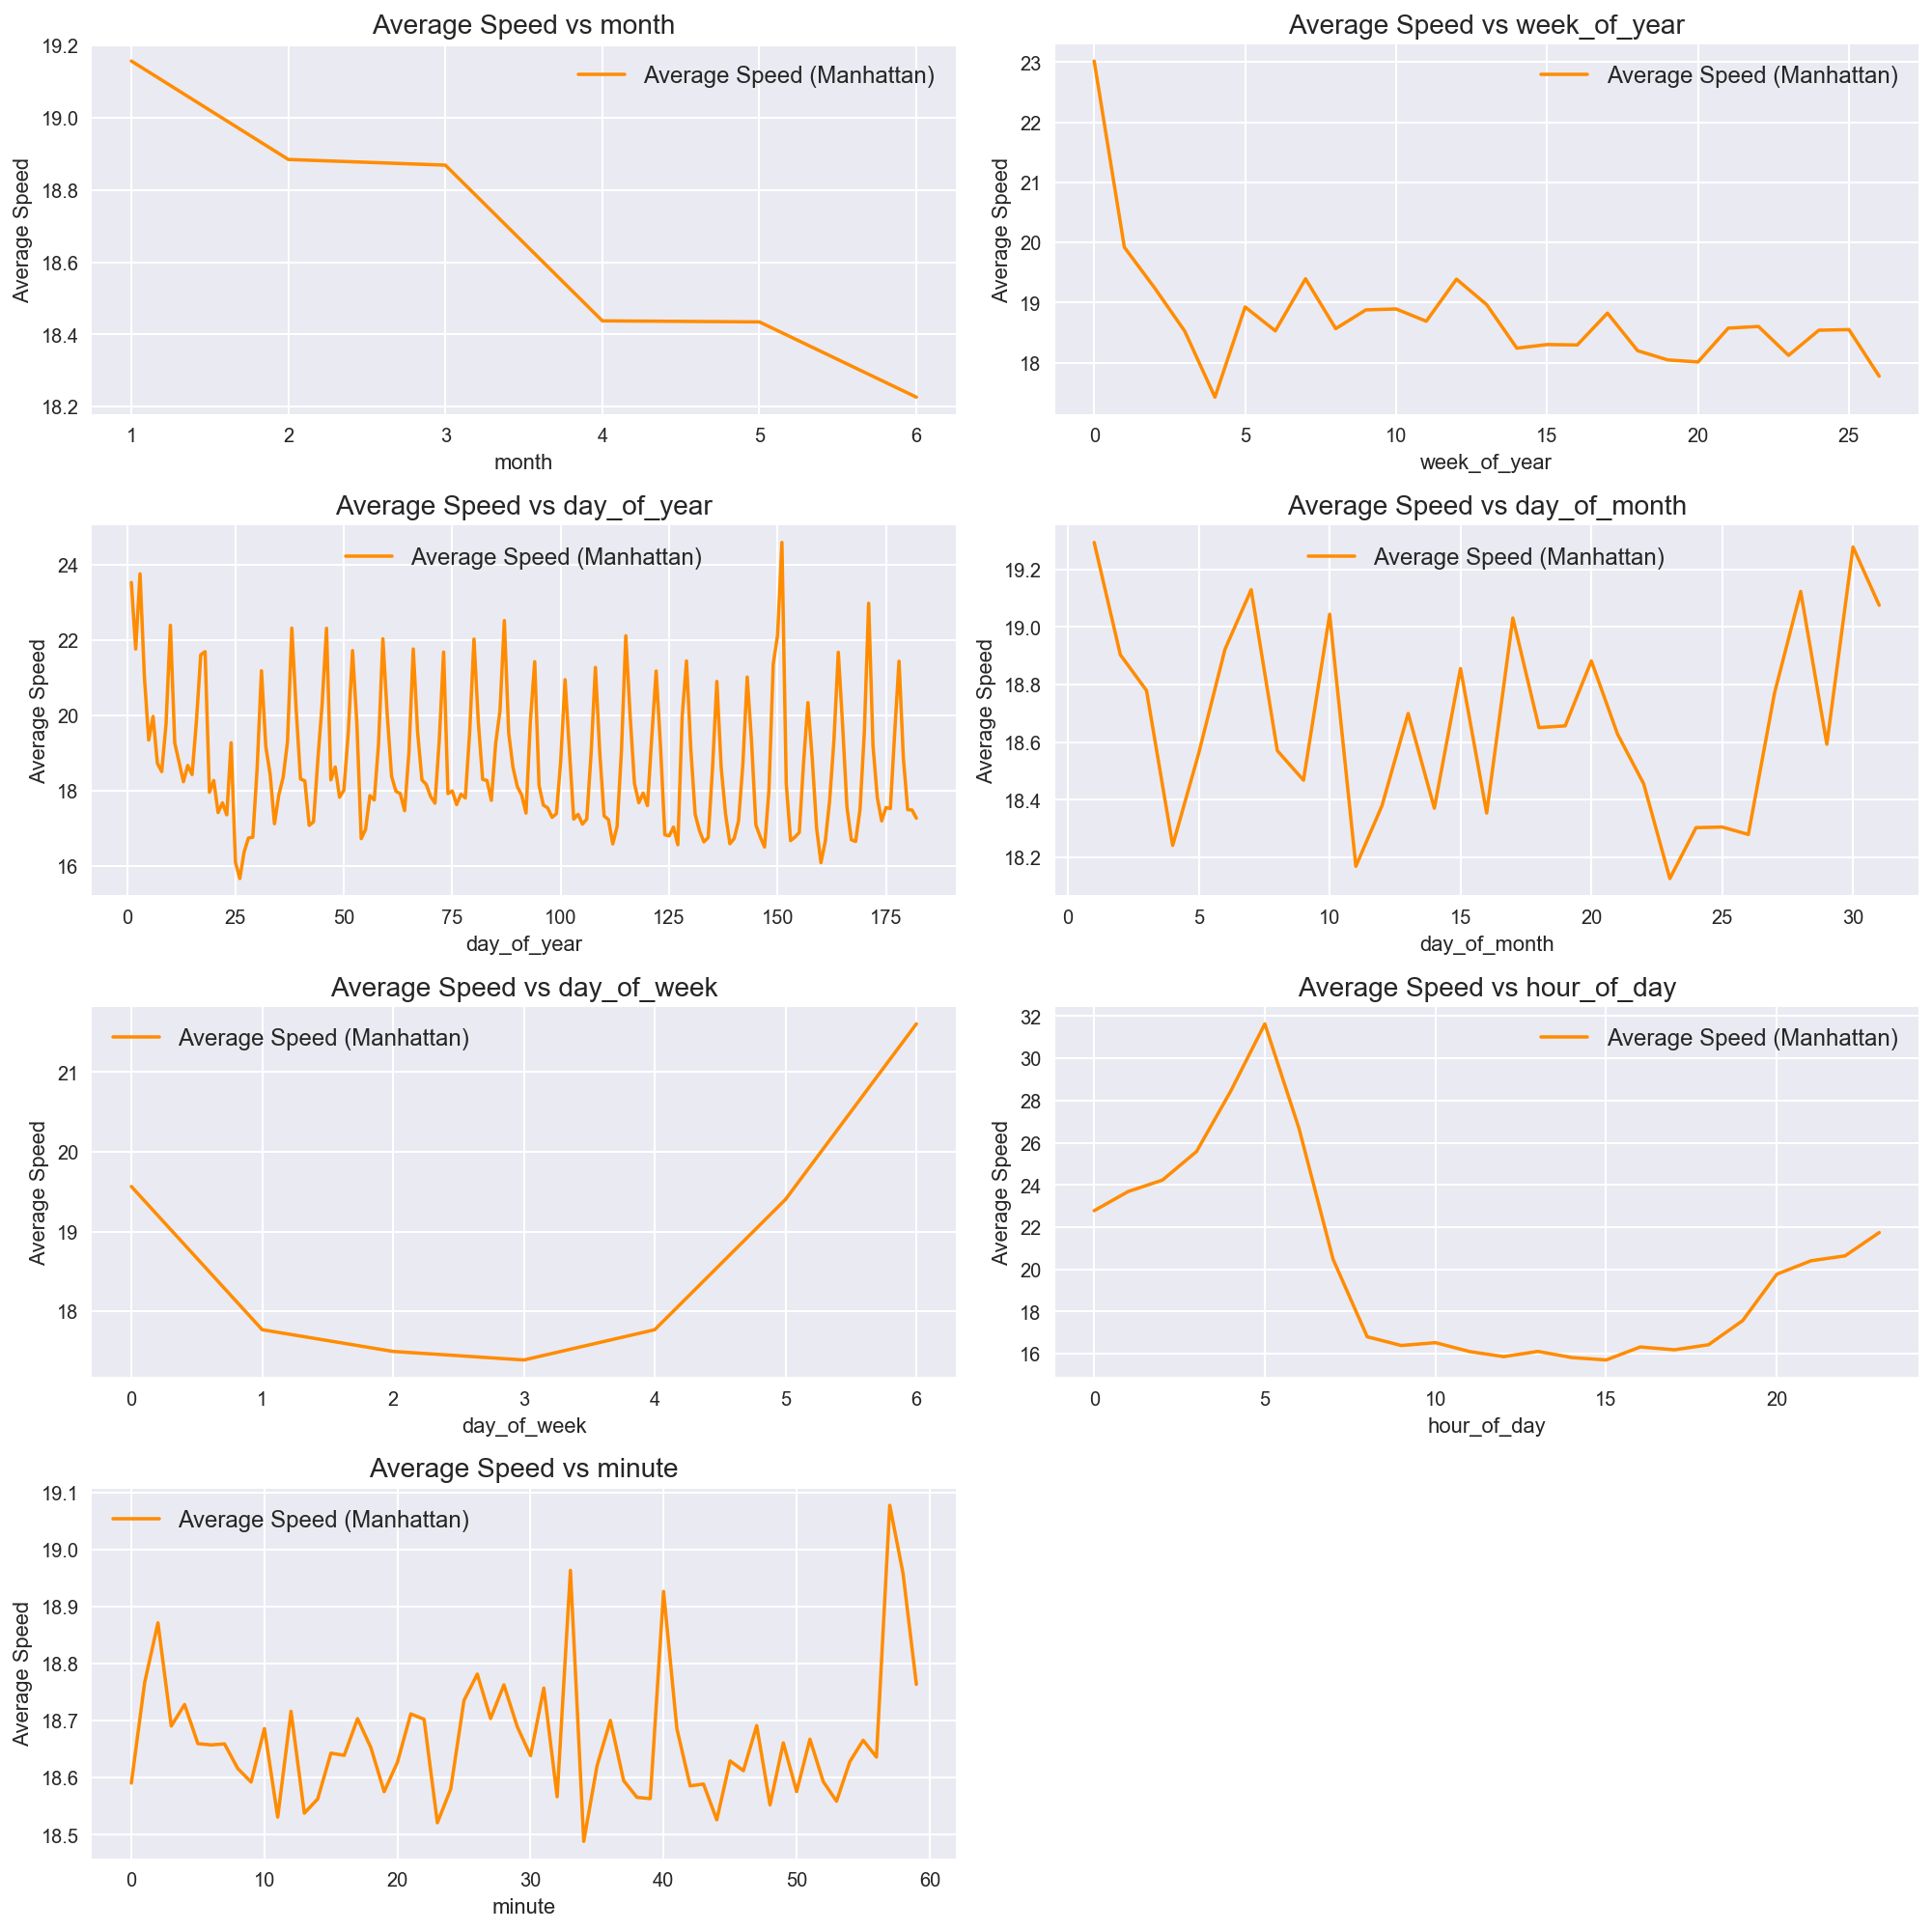

In [24]:
train_time_df['avg_speed_vinc'] =\
train_time_df.vincenty_distance / (train_time_df.trip_duration / 3600)
train_time_df['avg_speed_manh'] =\
train_time_df.manhattan_distance / (train_time_df.trip_duration / 3600)

plt.figure(figsize=(14, 14))
for i, feature in enumerate(time_features):
    plt.subplot(4, 2, i+1)
#     plt.plot(train_time_df.groupby(feature).avg_speed_vinc.mean(), 
#              label='Average Speed (Vincenty)')
    plt.plot(train_time_df.groupby(feature).avg_speed_manh.mean(),
             label='Average Speed (Manhattan)', c='darkorange')
    plt.title('Average Speed vs {}'.format(feature), fontsize=14)
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Average Speed')
    plt.legend(fontsize=12)
plt.tight_layout()

# Clustering

In [25]:
%%time
from sklearn.cluster import MiniBatchKMeans

sample_ix = np.random.permutation(len(coords))
n_clusters = 50
kmeans = MiniBatchKMeans(n_clusters = 50, batch_size=10000,
                         max_iter=1000, random_state=555).fit(coords[sample_ix])

train_time_df['pickup_cluster'] = kmeans.predict(train_time_df[['pickup_latitude', 'pickup_longitude']])
train_time_df['dropoff_cluster'] = kmeans.predict(train_time_df[['dropoff_latitude', 'dropoff_longitude']])

test_time_df['pickup_cluster'] = kmeans.predict(test_time_df[['pickup_latitude', 'pickup_longitude']])
test_time_df['dropoff_cluster'] = kmeans.predict(test_time_df[['dropoff_latitude', 'dropoff_longitude']])

CPU times: user 18.5 s, sys: 381 ms, total: 18.9 s
Wall time: 5.18 s


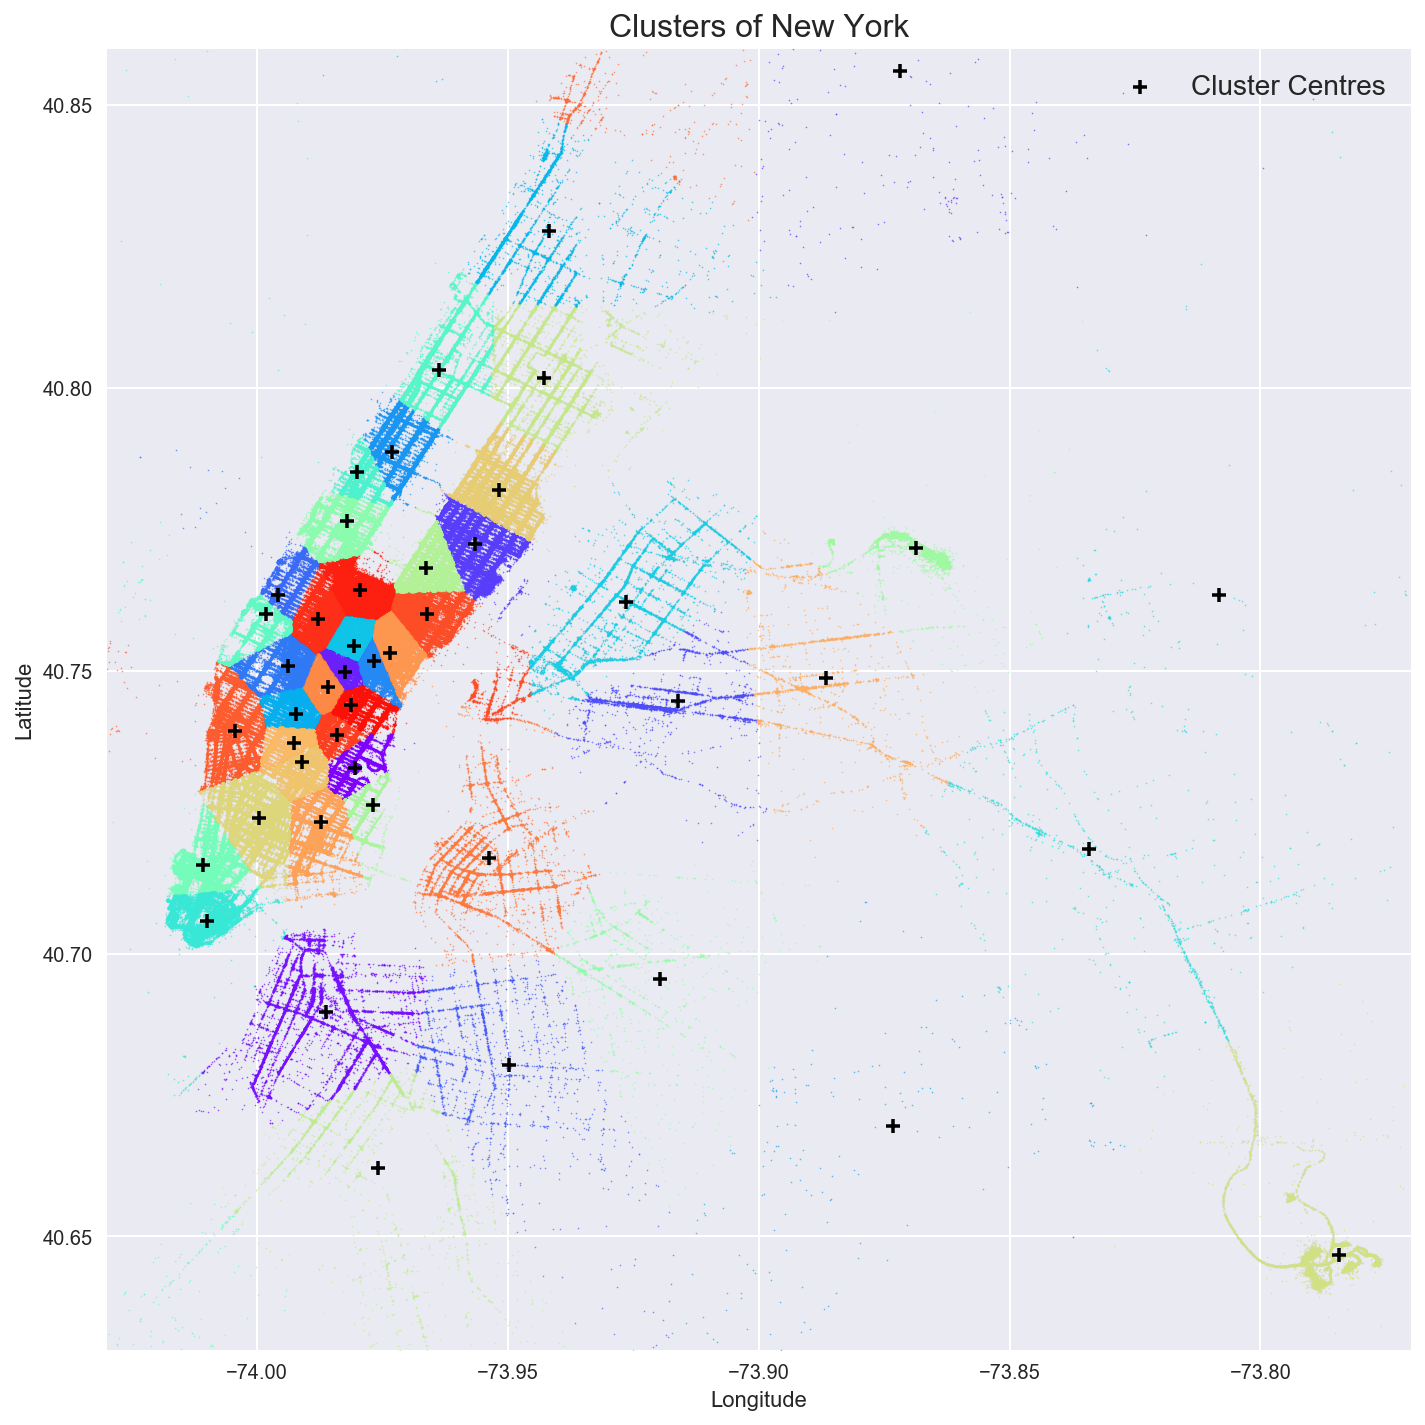

In [26]:
plt.figure(figsize=(10, 10))
colors=plt.cm.rainbow(train_time_df.pickup_cluster.unique()/n_clusters)
for cluster in train_time_df.pickup_cluster.unique():
    plt.scatter(train_time_df.pickup_longitude.values[train_time_df.pickup_cluster == cluster],
                train_time_df.pickup_latitude.values[train_time_df.pickup_cluster == cluster], 
                s=.3, alpha = .5, c=colors[cluster])
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=50, color='k', 
            label='Cluster Centres', marker='+')
plt.xlim(-74.03, -73.77)
plt.ylim(40.63, 40.86)
plt.title('Clusters of New York', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(fontsize=14)
plt.tight_layout()

# Aggregating

In [27]:
%%time
for feature in ['month', 'day_of_year', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_holiday',
                'pickup_cluster', 'dropoff_cluster']:
    gby = train_time_df.groupby(feature).mean()[['avg_speed_vinc', 'avg_speed_manh', 'log_trip_duration']]
    gby.columns = ['{0}_gby_{1}'.format(col, feature) for col in gby.columns]
    train_time_df = pd.merge(train_time_df, gby, how='left', left_on=feature, right_index=True)
    test_time_df = pd.merge(test_time_df, gby, how='left', left_on=feature, right_index=True)

CPU times: user 9.32 s, sys: 7.16 s, total: 16.5 s
Wall time: 16.5 s


In [28]:
%%time
group_freq = '60min'
df_all = pd.concat((train_time_df, test_time_df))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train_time_df['pickup_datetime_group'] = train_time_df['pickup_datetime'].dt.round(group_freq)
test_time_df['pickup_datetime_group'] = test_time_df['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train_time_df = train_time_df.merge(df_counts, on='id', how='left')
test_time_df = test_time_df.merge(df_counts, on='id', how='left')

CPU times: user 7.64 s, sys: 3.34 s, total: 11 s
Wall time: 11.5 s


In [29]:
%%time
for gby_cols in [['hour_of_day', 'pickup_cluster'],  ['hour_of_day', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train_time_df.groupby(gby_cols).mean()[['avg_speed_vinc']].reset_index()
    coord_count = train_time_df.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_vinc_{}'.format('_'.join(gby_cols)),
                                      'cnt_{}'.format('_'.join(gby_cols))]
    train_time_df = pd.merge(train_time_df, coord_stats, how='left', on=gby_cols)
    test_time_df = pd.merge(test_time_df, coord_stats, how='left', on=gby_cols)

CPU times: user 9.3 s, sys: 5.57 s, total: 14.9 s
Wall time: 14.9 s


In [30]:
%%time
# Count how many trips are going from each cluster over time
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train_time_df['pickup_cluster_count'] = train_time_df[['pickup_datetime_group', 
                                                       'pickup_cluster']].merge(
    pickup_counts, on=['pickup_datetime_group',
                       'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

test_time_df['pickup_cluster_count'] = test_time_df[['pickup_datetime_group',
                                                     'pickup_cluster']].merge(
    pickup_counts, on=['pickup_datetime_group',
                       'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

CPU times: user 3.18 s, sys: 1.25 s, total: 4.43 s
Wall time: 4.43 s


In [31]:
%%time
# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train_time_df['dropoff_cluster_count'] = train_time_df[['pickup_datetime_group',
                                                        'dropoff_cluster']].merge(
    dropoff_counts, on=['pickup_datetime_group',
                        'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

test_time_df['dropoff_cluster_count'] = test_time_df[['pickup_datetime_group',
                                                      'dropoff_cluster']].merge(
    dropoff_counts, on=['pickup_datetime_group',
                        'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

CPU times: user 3.02 s, sys: 934 ms, total: 3.96 s
Wall time: 3.96 s


In [32]:
cat_features = ['vendor_id', 'store_and_fwd_flag', 'month', 'day_of_week_name',
               'is_weekend', 'is_holiday', 'is_school_holiday', 'is_superbowl', 'is_easter',
                'is_valentines', 'is_mothers_day']
# num_features = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
#                 'dropoff_latitude', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week',
#                 'hour_of_day', 'minute', 'log_distance']

In [33]:
final_train_df = train_time_df.drop(['id', 'trip_duration', 'log_trip_duration', 'pickup_datetime', 
                                     'avg_speed_vinc', 'avg_speed_manh', 'pickup_datetime_group'],
                                    axis=1)
final_test_df = test_time_df.drop(['id', 'pickup_datetime', 'pickup_datetime_group'], axis=1)
final_train_df.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  month  \
0         -73.964630         40.765602                  N      3   
1         -73.999481         40.731152                  N      6   
2         -74.005333         40.710087                  N      1   
3         -74.012268         40.706718                  N      4   
4         -73.972923         40.782520                  N      3   

   week_of_year  day_of_year  day_of_month  day_of_week day_of_week_name  \
0            11           74            14            0           Monday   
1            23          164            12            6           Sunday   
2             3           19            19            1          Tuesday   
3            14           97             6            2        Wednesday   
4            12           86            26            5         Saturday   

   hour_of_day  minute is_weekend is_holiday  is_school_holiday  is_superbowl  \
0           17      24      False      False              False         False   
1            0      43       True      False              False         False   
2           11      35      False      False              False         False   
3           19      32      False      False              False         False   
4           13      30       True      False              False         False   

   is_easter  is_valentines  is_mothers_day  pickup_pc1  pickup_pc2  \
0      False          False           False    0.007645    0.017037   
1      False          False           False    0.007651   -0.012387   
2      False          False           False    0.004760    0.012861   
3      False          False           False    0.038327   -0.029190   
4      False          False           False   -0.002940    0.041725   

   dropoff_pc1  dropoff_pc2  vincenty_distance  pca_vincenty_distance  \
0    -0.009710     0.013667           1.502172               1.955383   
1     0.027123    -0.018655           1.808660               2.263332   
2     0.034215    -0.039335           6.379687               6.661039   
3     0.041338    -0.042286           1.483632               1.495433   
4    -0.002436     0.031048           1.187038               1.189940   

   manhattan_distance  pca_manhattan_distance  pickup_cluster  \
0            1.738860                2.294230              34   
1            2.433520                2.850820              30   
2            8.201361                9.067442              34   
3            1.659868                1.790767              33   
4            1.197933                1.244440              28   

   dropoff_cluster  avg_speed_vinc_gby_month  avg_speed_manh_gby_month  \
0                1                 14.598264                 18.868773   
1                0                 14.085040                 18.226280   
2               18                 14.807616                 19.157083   
3               18                 14.257461                 18.437540   
4               28                 14.598264                 18.868773   

   log_trip_duration_gby_month  avg_speed_vinc_gby_day_of_year  \
0                     6.450618                       13.859760   
1                     6.517381                       16.730777   
2                     6.419927                       13.905379   
3                     6.481256                       13.552345   
4                     6.450618                       15.553665   

   avg_speed_manh_gby_day_of_year  log_trip_duration_gby_day_of_year  \
0                       17.922050                           6.443342  

In [34]:
%%time
# Try keeping all columns
print('Creating dummy variables for categorical features...')
final_train_df = pd.get_dummies(final_train_df, columns=cat_features, sparse=True, drop_first=False)
final_test_df = pd.get_dummies(final_test_df, columns=cat_features, sparse=True, drop_first=False)

Creating dummy variables for categorical features...
CPU times: user 56.9 s, sys: 2.32 s, total: 59.2 s
Wall time: 1min


In [35]:
final_test_df.head()

passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.988129        40.732029         -73.990173   
1                1        -73.964203        40.679993         -73.959808   
2                1        -73.997437        40.737583         -73.986160   
3                1        -73.956070        40.771900         -73.986427   
4                1        -73.970215        40.761475         -73.961510   

   dropoff_latitude  week_of_year  day_of_year  day_of_month  day_of_week  \
0         40.756680            26          182            30            3   
1         40.655403            26          182            30            3   
2         40.729523            26          182            30            3   
3         40.730469            26          182            30            3   
4         40.755890            26          182            30            3   

   hour_of_day  minute  pickup_pc1  pickup_pc2  dropoff_pc1  dropoff_pc2  \
0           23      59    0.015739   -0.018453     0.016317     0.006276   
1           23      59   -0.005057   -0.071817    -0.007985    -0.096624   
2           23      59    0.024701   -0.012356     0.013923    -0.021071   
3           23      59   -0.018629    0.019446     0.014133    -0.020111   
4           23      59   -0.003890    0.009878    -0.012249     0.003787   

   vincenty_distance  pca_vincenty_distance  manhattan_distance  \
0           2.742863               2.753503            2.910145   
1           2.755774               2.780410            3.102124   
2           1.307112               1.536751            1.847585   
3           5.266978               5.702133            7.163830   
4           0.961745               1.146300            1.355221   

   pca_manhattan_distance  pickup_cluster  dropoff_cluster  \
0                2.816725              46               42   
1                3.085239              41                5   
2                2.161967              45               35   
3                8.026141              22               46   
4                1.602318              31               31   

   avg_speed_vinc_gby_month  avg_speed_manh_gby_month  \
0                  14.08504                  18.22628   
1                  14.08504                  18.22628   
2                  14.08504                  18.22628   
3                  14.08504                  18.22628   
4                  14.08504                  18.22628   

   log_trip_duration_gby_month  avg_speed_vinc_gby_day_of_year  \
0                     6.517381                       13.342333   
1                     6.517381                       13.342333   
2                     6.517381                       13.342333   
3                     6.517381                       13.342333   
4                     6.517381                       13.342333   

   avg_speed_manh_gby_day_of_year  log_trip_duration_gby_day_of_year  \
0                       17.271214                           6.554559   
1                       17.271214                           6.554559   
2                       17.271214                           6.554559   
3                       17.271214                           6.554559   
4                       17.271214                           6.554559   

   avg_speed_vinc_gby_day_of_week  avg_speed_manh_gby_day_of_week  \
0                       13.455172                       17.390911   
1                       13.455172                       17.390911   
2                       13.455172                       17.390911   
3                       13.455172                       17.390911   
4                       13.455172                       17.390911   

   log_trip_duration_gby_day_of_week  avg_speed_vinc_gby_hour_of_day  \
0                            6.52964                       16.876495   
1                            6.52964                       16.876495   
2                            6.52964          

In [36]:
X = final_train_df.as_matrix()
X_test = final_test_df.as_matrix()
y = train_df.log_trip_duration.values
print('Shape of X: {0} | Shape of y: {1}\nShape of X_test: {2}'.format(
    X.shape, y.shape, X_test.shape))

Shape of X: (1454699, 85) | Shape of y: (1454699,)
Shape of X_test: (625134, 85)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=555)
print('Shape of X_train is: {0} | Shape of y_train is: {1}'.format(X_train.shape, y_train.shape), 
      '\nShape of X_val: {0} | Shape of y_val is: {1}'.format(X_val.shape, y_val.shape))

Shape of X_train is: (1163759, 85) | Shape of y_train is: (1163759,) 
Shape of X_val: (290940, 85) | Shape of y_val is: (290940,)


# Machine Learning

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

/Users/hugobmachado/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
regressor_xgb = XGBRegressor(n_estimators=10, nthread=-1, seed=555)
regressor_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                  eval_metric='rmse', verbose=True)
pred_xgb_val = regressor_xgb.predict(X_val)
print('Validation RMSLE: {}'.format(np.sqrt(mean_squared_error(pred_xgb_val, y_val))))

[0]	validation_0-rmse:5.41679	validation_1-rmse:5.41738
[1]	validation_0-rmse:4.87925	validation_1-rmse:4.87981
[2]	validation_0-rmse:4.39582	validation_1-rmse:4.39636
[3]	validation_0-rmse:3.96113	validation_1-rmse:3.96166
[4]	validation_0-rmse:3.57036	validation_1-rmse:3.57087
[5]	validation_0-rmse:3.21913	validation_1-rmse:3.21959
[6]	validation_0-rmse:2.90357	validation_1-rmse:2.904
[7]	validation_0-rmse:2.62014	validation_1-rmse:2.62051
[8]	validation_0-rmse:2.36572	validation_1-rmse:2.3661
[9]	validation_0-rmse:2.13742	validation_1-rmse:2.13778
Validation RMSLE: 2.1377812327057395


In [40]:
param_distribs = {
    'max_depth': ss.randint(low=2, high=10),
#     'learning_rate': ss.reciprocal(0.01, 1),
#     'n_estimators': ss.randint(low=50, high=1000),
    'gamma': ss.expon(scale=1.0),
    'min_child_weight': ss.randint(low=1, high=12),
    'max_delta_step': ss.randint(low=0, high=12),
    'subsample': ss.reciprocal(0.1, 1),
    'colsample_bytree': ss.reciprocal(0.1, 1),
    'reg_lambda': ss.reciprocal(0.0001, 1),
    'reg_alpha': ss.reciprocal(0.0001, 1)
}

regressor_xgb = XGBRegressor(n_estimators=50, learning_rate=0.1, nthread=-1, seed=555)
rnd_search_xgb = RandomizedSearchCV(
    estimator=regressor_xgb, param_distributions=param_distribs,
    n_iter=50, cv=3, scoring='neg_mean_squared_error',
    verbose=1, n_jobs=-1, random_state=555
)

rnd_search_xgb.fit(X, y);
print('Best Score: {}'.format(np.sqrt(-rnd_search_xgb.best_score_)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 90.1min finished


Best Score: 0.35165192676688733


In [43]:
regressor_xgb = rnd_search_xgb.best_estimator_
print('Best parameters found are:', rnd_search_xgb.best_params_)

Best parameters found are: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.61384016608185654, 'reg_alpha': 0.22176319536023675, 'reg_lambda': 0.00043875630177242757, 'gamma': 0.74558758236297262, 'max_delta_step': 0, 'colsample_bytree': 0.76302847690230025}


In [45]:
regressor_xgb.n_estimators = 5000
# regressor_xgb.learning_rate = 0.1

In [46]:
regressor_xgb.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.76302847690230025, gamma=0.74558758236297262,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=None, n_estimators=5000, nthread=-1,
       objective='reg:linear', reg_alpha=0.22176319536023675,
       reg_lambda=0.00043875630177242757, scale_pos_weight=1, seed=555,
       silent=True, subsample=0.61384016608185654)>

In [47]:
%%time
regressor_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                  eval_metric='rmse', early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:5.41572	validation_1-rmse:5.41629
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4.87698	validation_1-rmse:4.87746
[2]	validation_0-rmse:4.39239	validation_1-rmse:4.39284
[3]	validation_0-rmse:3.9566	validation_1-rmse:3.95697
[4]	validation_0-rmse:3.56481	validation_1-rmse:3.56519
[5]	validation_0-rmse:3.21242	validation_1-rmse:3.2128
[6]	validation_0-rmse:2.89585	validation_1-rmse:2.89624
[7]	validation_0-rmse:2.61122	validation_1-rmse:2.6116
[8]	validation_0-rmse:2.35557	validation_1-rmse:2.35597
[9]	validation_0-rmse:2.12606	validation_1-rmse:2.12651
[10]	validation_0-rmse:1.92015	validation_1-rmse:1.92068
[11]	validation_0-rmse:1.73544	validation_1-rmse:1.73603
[12]	validation_0-rmse:1.56992	validation_1-rmse:1.57056
[13]	validation_0-rmse:1.42172	validation_1-rmse:1.42245
[14]	validation_0-rmse:1.28914	validation_1-rmse:1.28996

[137]	validation_0-rmse:0.313105	validation_1-rmse:0.338011
[138]	validation_0-rmse:0.31305	validation_1-rmse:0.337997
[139]	validation_0-rmse:0.312857	validation_1-rmse:0.337977
[140]	validation_0-rmse:0.312473	validation_1-rmse:0.337767
[141]	validation_0-rmse:0.312293	validation_1-rmse:0.337799
[142]	validation_0-rmse:0.312172	validation_1-rmse:0.337749
[143]	validation_0-rmse:0.311839	validation_1-rmse:0.337599
[144]	validation_0-rmse:0.311663	validation_1-rmse:0.337588
[145]	validation_0-rmse:0.311535	validation_1-rmse:0.337555
[146]	validation_0-rmse:0.311357	validation_1-rmse:0.337463
[147]	validation_0-rmse:0.311024	validation_1-rmse:0.337326
[148]	validation_0-rmse:0.310939	validation_1-rmse:0.337279
[149]	validation_0-rmse:0.310785	validation_1-rmse:0.337235
[150]	validation_0-rmse:0.310699	validation_1-rmse:0.337221
[151]	validation_0-rmse:0.310433	validation_1-rmse:0.337179
[152]	validation_0-rmse:0.310135	validation_1-rmse:0.337051
[153]	validation_0-rmse:0.310015	validati

[274]	validation_0-rmse:0.293949	validation_1-rmse:0.333002
[275]	validation_0-rmse:0.293864	validation_1-rmse:0.332997
[276]	validation_0-rmse:0.2938	validation_1-rmse:0.332953
[277]	validation_0-rmse:0.293715	validation_1-rmse:0.332956
[278]	validation_0-rmse:0.293624	validation_1-rmse:0.332932
[279]	validation_0-rmse:0.293573	validation_1-rmse:0.332902
[280]	validation_0-rmse:0.293525	validation_1-rmse:0.332893
[281]	validation_0-rmse:0.293427	validation_1-rmse:0.332844
[282]	validation_0-rmse:0.293295	validation_1-rmse:0.332792
[283]	validation_0-rmse:0.29324	validation_1-rmse:0.332805
[284]	validation_0-rmse:0.293106	validation_1-rmse:0.332745
[285]	validation_0-rmse:0.293075	validation_1-rmse:0.332722
[286]	validation_0-rmse:0.292961	validation_1-rmse:0.332658
[287]	validation_0-rmse:0.292874	validation_1-rmse:0.332644
[288]	validation_0-rmse:0.292779	validation_1-rmse:0.332626
[289]	validation_0-rmse:0.292682	validation_1-rmse:0.332569
[290]	validation_0-rmse:0.292502	validation

[412]	validation_0-rmse:0.282735	validation_1-rmse:0.330095
[413]	validation_0-rmse:0.282616	validation_1-rmse:0.330057
[414]	validation_0-rmse:0.282525	validation_1-rmse:0.330035
[415]	validation_0-rmse:0.282495	validation_1-rmse:0.330021
[416]	validation_0-rmse:0.282354	validation_1-rmse:0.329967
[417]	validation_0-rmse:0.282309	validation_1-rmse:0.329971
[418]	validation_0-rmse:0.282264	validation_1-rmse:0.329949
[419]	validation_0-rmse:0.282228	validation_1-rmse:0.329947
[420]	validation_0-rmse:0.282176	validation_1-rmse:0.329941
[421]	validation_0-rmse:0.282112	validation_1-rmse:0.329935
[422]	validation_0-rmse:0.282043	validation_1-rmse:0.329909
[423]	validation_0-rmse:0.281949	validation_1-rmse:0.329882
[424]	validation_0-rmse:0.281852	validation_1-rmse:0.329843
[425]	validation_0-rmse:0.281702	validation_1-rmse:0.329754
[426]	validation_0-rmse:0.28164	validation_1-rmse:0.329723
[427]	validation_0-rmse:0.281525	validation_1-rmse:0.329699
[428]	validation_0-rmse:0.28147	validatio

[549]	validation_0-rmse:0.274273	validation_1-rmse:0.328023
[550]	validation_0-rmse:0.274189	validation_1-rmse:0.327995
[551]	validation_0-rmse:0.274128	validation_1-rmse:0.327984
[552]	validation_0-rmse:0.274092	validation_1-rmse:0.327984
[553]	validation_0-rmse:0.273955	validation_1-rmse:0.327929
[554]	validation_0-rmse:0.273877	validation_1-rmse:0.327895
[555]	validation_0-rmse:0.273815	validation_1-rmse:0.327864
[556]	validation_0-rmse:0.273795	validation_1-rmse:0.327868
[557]	validation_0-rmse:0.273737	validation_1-rmse:0.327847
[558]	validation_0-rmse:0.273671	validation_1-rmse:0.327829
[559]	validation_0-rmse:0.273606	validation_1-rmse:0.327841
[560]	validation_0-rmse:0.273577	validation_1-rmse:0.327826
[561]	validation_0-rmse:0.273493	validation_1-rmse:0.327809
[562]	validation_0-rmse:0.273455	validation_1-rmse:0.327794
[563]	validation_0-rmse:0.273394	validation_1-rmse:0.327781
[564]	validation_0-rmse:0.27336	validation_1-rmse:0.327781
[565]	validation_0-rmse:0.273243	validati

[686]	validation_0-rmse:0.267504	validation_1-rmse:0.326599
[687]	validation_0-rmse:0.267474	validation_1-rmse:0.326596
[688]	validation_0-rmse:0.267452	validation_1-rmse:0.326592
[689]	validation_0-rmse:0.267411	validation_1-rmse:0.326599
[690]	validation_0-rmse:0.26732	validation_1-rmse:0.326563
[691]	validation_0-rmse:0.267305	validation_1-rmse:0.326558
[692]	validation_0-rmse:0.267282	validation_1-rmse:0.326552
[693]	validation_0-rmse:0.267209	validation_1-rmse:0.326531
[694]	validation_0-rmse:0.2672	validation_1-rmse:0.326528
[695]	validation_0-rmse:0.267106	validation_1-rmse:0.326478
[696]	validation_0-rmse:0.267051	validation_1-rmse:0.326475
[697]	validation_0-rmse:0.267017	validation_1-rmse:0.326466
[698]	validation_0-rmse:0.266937	validation_1-rmse:0.32643
[699]	validation_0-rmse:0.266911	validation_1-rmse:0.326417
[700]	validation_0-rmse:0.266887	validation_1-rmse:0.32641
[701]	validation_0-rmse:0.266828	validation_1-rmse:0.326376
[702]	validation_0-rmse:0.266757	validation_1

[824]	validation_0-rmse:0.262427	validation_1-rmse:0.32564
[825]	validation_0-rmse:0.262362	validation_1-rmse:0.325613
[826]	validation_0-rmse:0.262342	validation_1-rmse:0.325615
[827]	validation_0-rmse:0.26229	validation_1-rmse:0.325587
[828]	validation_0-rmse:0.262271	validation_1-rmse:0.325591
[829]	validation_0-rmse:0.262224	validation_1-rmse:0.32558
[830]	validation_0-rmse:0.262212	validation_1-rmse:0.32558
[831]	validation_0-rmse:0.262166	validation_1-rmse:0.325559
[832]	validation_0-rmse:0.262142	validation_1-rmse:0.325549
[833]	validation_0-rmse:0.262113	validation_1-rmse:0.325539
[834]	validation_0-rmse:0.262086	validation_1-rmse:0.325529
[835]	validation_0-rmse:0.262062	validation_1-rmse:0.325519
[836]	validation_0-rmse:0.262046	validation_1-rmse:0.325514
[837]	validation_0-rmse:0.262031	validation_1-rmse:0.325517
[838]	validation_0-rmse:0.262006	validation_1-rmse:0.325507
[839]	validation_0-rmse:0.261964	validation_1-rmse:0.325499
[840]	validation_0-rmse:0.26193	validation_1

[962]	validation_0-rmse:0.257919	validation_1-rmse:0.3247
[963]	validation_0-rmse:0.257907	validation_1-rmse:0.324701
[964]	validation_0-rmse:0.257873	validation_1-rmse:0.324694
[965]	validation_0-rmse:0.257859	validation_1-rmse:0.324684
[966]	validation_0-rmse:0.257827	validation_1-rmse:0.324684
[967]	validation_0-rmse:0.257793	validation_1-rmse:0.324682
[968]	validation_0-rmse:0.257778	validation_1-rmse:0.324683
[969]	validation_0-rmse:0.257752	validation_1-rmse:0.324685
[970]	validation_0-rmse:0.257718	validation_1-rmse:0.32468
[971]	validation_0-rmse:0.25769	validation_1-rmse:0.324686
[972]	validation_0-rmse:0.257667	validation_1-rmse:0.324682
[973]	validation_0-rmse:0.257599	validation_1-rmse:0.324653
[974]	validation_0-rmse:0.257574	validation_1-rmse:0.32465
[975]	validation_0-rmse:0.257539	validation_1-rmse:0.324645
[976]	validation_0-rmse:0.257517	validation_1-rmse:0.324646
[977]	validation_0-rmse:0.257497	validation_1-rmse:0.324638
[978]	validation_0-rmse:0.257453	validation_1

[1098]	validation_0-rmse:0.254252	validation_1-rmse:0.324146
[1099]	validation_0-rmse:0.254228	validation_1-rmse:0.324138
[1100]	validation_0-rmse:0.254183	validation_1-rmse:0.324119
[1101]	validation_0-rmse:0.254139	validation_1-rmse:0.324102
[1102]	validation_0-rmse:0.254135	validation_1-rmse:0.324101
[1103]	validation_0-rmse:0.25411	validation_1-rmse:0.324106
[1104]	validation_0-rmse:0.254091	validation_1-rmse:0.32411
[1105]	validation_0-rmse:0.254039	validation_1-rmse:0.324103
[1106]	validation_0-rmse:0.254018	validation_1-rmse:0.324106
[1107]	validation_0-rmse:0.253983	validation_1-rmse:0.324106
[1108]	validation_0-rmse:0.253968	validation_1-rmse:0.32411
[1109]	validation_0-rmse:0.253962	validation_1-rmse:0.32411
[1110]	validation_0-rmse:0.253942	validation_1-rmse:0.324109
[1111]	validation_0-rmse:0.253913	validation_1-rmse:0.324104
[1112]	validation_0-rmse:0.253887	validation_1-rmse:0.324097
[1113]	validation_0-rmse:0.253838	validation_1-rmse:0.324091
[1114]	validation_0-rmse:0.2

[1233]	validation_0-rmse:0.251177	validation_1-rmse:0.32365
[1234]	validation_0-rmse:0.251161	validation_1-rmse:0.323642
[1235]	validation_0-rmse:0.251147	validation_1-rmse:0.323636
[1236]	validation_0-rmse:0.251132	validation_1-rmse:0.323644
[1237]	validation_0-rmse:0.251108	validation_1-rmse:0.323639
[1238]	validation_0-rmse:0.251099	validation_1-rmse:0.323638
[1239]	validation_0-rmse:0.251076	validation_1-rmse:0.323631
[1240]	validation_0-rmse:0.251048	validation_1-rmse:0.323631
[1241]	validation_0-rmse:0.251045	validation_1-rmse:0.32363
[1242]	validation_0-rmse:0.251018	validation_1-rmse:0.323629
[1243]	validation_0-rmse:0.25101	validation_1-rmse:0.323626
[1244]	validation_0-rmse:0.250993	validation_1-rmse:0.323629
[1245]	validation_0-rmse:0.250966	validation_1-rmse:0.323626
[1246]	validation_0-rmse:0.250956	validation_1-rmse:0.323626
[1247]	validation_0-rmse:0.250941	validation_1-rmse:0.323623
[1248]	validation_0-rmse:0.250929	validation_1-rmse:0.32362
[1249]	validation_0-rmse:0.2

[1368]	validation_0-rmse:0.248563	validation_1-rmse:0.323274
[1369]	validation_0-rmse:0.248554	validation_1-rmse:0.323273
[1370]	validation_0-rmse:0.248531	validation_1-rmse:0.323271
[1371]	validation_0-rmse:0.248517	validation_1-rmse:0.323262
[1372]	validation_0-rmse:0.248493	validation_1-rmse:0.323264
[1373]	validation_0-rmse:0.248484	validation_1-rmse:0.323265
[1374]	validation_0-rmse:0.248472	validation_1-rmse:0.323261
[1375]	validation_0-rmse:0.24846	validation_1-rmse:0.323254
[1376]	validation_0-rmse:0.248443	validation_1-rmse:0.323253
[1377]	validation_0-rmse:0.248437	validation_1-rmse:0.323251
[1378]	validation_0-rmse:0.248408	validation_1-rmse:0.323242
[1379]	validation_0-rmse:0.248396	validation_1-rmse:0.323241
[1380]	validation_0-rmse:0.248382	validation_1-rmse:0.323237
[1381]	validation_0-rmse:0.248362	validation_1-rmse:0.323235
[1382]	validation_0-rmse:0.248344	validation_1-rmse:0.323228
[1383]	validation_0-rmse:0.248335	validation_1-rmse:0.323228
[1384]	validation_0-rmse:

[1503]	validation_0-rmse:0.24636	validation_1-rmse:0.323021
[1504]	validation_0-rmse:0.246343	validation_1-rmse:0.323017
[1505]	validation_0-rmse:0.246333	validation_1-rmse:0.323014
[1506]	validation_0-rmse:0.246318	validation_1-rmse:0.323016
[1507]	validation_0-rmse:0.246307	validation_1-rmse:0.323017
[1508]	validation_0-rmse:0.246302	validation_1-rmse:0.323017
[1509]	validation_0-rmse:0.246294	validation_1-rmse:0.323015
[1510]	validation_0-rmse:0.246267	validation_1-rmse:0.323006
[1511]	validation_0-rmse:0.246263	validation_1-rmse:0.323004
[1512]	validation_0-rmse:0.246254	validation_1-rmse:0.323004
[1513]	validation_0-rmse:0.246252	validation_1-rmse:0.323003
[1514]	validation_0-rmse:0.246236	validation_1-rmse:0.322998
[1515]	validation_0-rmse:0.246217	validation_1-rmse:0.322996
[1516]	validation_0-rmse:0.2462	validation_1-rmse:0.322993
[1517]	validation_0-rmse:0.246184	validation_1-rmse:0.322993
[1518]	validation_0-rmse:0.246169	validation_1-rmse:0.322991
[1519]	validation_0-rmse:0.

[1638]	validation_0-rmse:0.244196	validation_1-rmse:0.322695
[1639]	validation_0-rmse:0.244182	validation_1-rmse:0.322691
[1640]	validation_0-rmse:0.244169	validation_1-rmse:0.322687
[1641]	validation_0-rmse:0.244156	validation_1-rmse:0.322683
[1642]	validation_0-rmse:0.244135	validation_1-rmse:0.322677
[1643]	validation_0-rmse:0.24412	validation_1-rmse:0.322673
[1644]	validation_0-rmse:0.244113	validation_1-rmse:0.322673
[1645]	validation_0-rmse:0.244091	validation_1-rmse:0.322671
[1646]	validation_0-rmse:0.244075	validation_1-rmse:0.32267
[1647]	validation_0-rmse:0.244061	validation_1-rmse:0.322666
[1648]	validation_0-rmse:0.244038	validation_1-rmse:0.322659
[1649]	validation_0-rmse:0.24403	validation_1-rmse:0.322664
[1650]	validation_0-rmse:0.244028	validation_1-rmse:0.322663
[1651]	validation_0-rmse:0.244025	validation_1-rmse:0.322665
[1652]	validation_0-rmse:0.244013	validation_1-rmse:0.322665
[1653]	validation_0-rmse:0.244004	validation_1-rmse:0.322667
[1654]	validation_0-rmse:0.

[1773]	validation_0-rmse:0.242315	validation_1-rmse:0.32243
[1774]	validation_0-rmse:0.242308	validation_1-rmse:0.32243
[1775]	validation_0-rmse:0.242288	validation_1-rmse:0.322429
[1776]	validation_0-rmse:0.24228	validation_1-rmse:0.322429
[1777]	validation_0-rmse:0.242271	validation_1-rmse:0.322426
[1778]	validation_0-rmse:0.242255	validation_1-rmse:0.322431
[1779]	validation_0-rmse:0.242243	validation_1-rmse:0.322432
[1780]	validation_0-rmse:0.242219	validation_1-rmse:0.322431
[1781]	validation_0-rmse:0.242213	validation_1-rmse:0.322429
[1782]	validation_0-rmse:0.242204	validation_1-rmse:0.322428
[1783]	validation_0-rmse:0.242186	validation_1-rmse:0.322423
[1784]	validation_0-rmse:0.242171	validation_1-rmse:0.322425
[1785]	validation_0-rmse:0.242167	validation_1-rmse:0.322425
[1786]	validation_0-rmse:0.242146	validation_1-rmse:0.322423
[1787]	validation_0-rmse:0.242141	validation_1-rmse:0.32242
[1788]	validation_0-rmse:0.242125	validation_1-rmse:0.322422
[1789]	validation_0-rmse:0.2

[1908]	validation_0-rmse:0.240637	validation_1-rmse:0.322218
[1909]	validation_0-rmse:0.240634	validation_1-rmse:0.322218
[1910]	validation_0-rmse:0.240614	validation_1-rmse:0.32222
[1911]	validation_0-rmse:0.240604	validation_1-rmse:0.322221
[1912]	validation_0-rmse:0.240592	validation_1-rmse:0.322231
[1913]	validation_0-rmse:0.240568	validation_1-rmse:0.322226
[1914]	validation_0-rmse:0.240545	validation_1-rmse:0.322218
[1915]	validation_0-rmse:0.240527	validation_1-rmse:0.322216
[1916]	validation_0-rmse:0.24051	validation_1-rmse:0.322214
[1917]	validation_0-rmse:0.240501	validation_1-rmse:0.322214
[1918]	validation_0-rmse:0.24049	validation_1-rmse:0.322216
[1919]	validation_0-rmse:0.240469	validation_1-rmse:0.322214
[1920]	validation_0-rmse:0.240468	validation_1-rmse:0.322214
[1921]	validation_0-rmse:0.240459	validation_1-rmse:0.322216
[1922]	validation_0-rmse:0.240435	validation_1-rmse:0.322211
[1923]	validation_0-rmse:0.240429	validation_1-rmse:0.32221
[1924]	validation_0-rmse:0.2

XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.76302847690230025, gamma=0.74558758236297262,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=None, n_estimators=5000, nthread=-1,
       objective='reg:linear', reg_alpha=0.22176319536023675,
       reg_lambda=0.00043875630177242757, scale_pos_weight=1, seed=555,
       silent=True, subsample=0.61384016608185654)

In [48]:
%%time
pred_xgb_tr = regressor_xgb.predict(X_train)
pred_xgb_val = regressor_xgb.predict(X_val)
print('Training RMSLE: {:.5f}'.format(np.sqrt(mean_squared_error(pred_xgb_tr, y_train))))
print('Validation RMSLE: {:.5f}'.format(np.sqrt(mean_squared_error(pred_xgb_val, y_val))))

Training RMSLE: 0.23971
Validation RMSLE: 0.32213
CPU times: user 6min 39s, sys: 3.98 s, total: 6min 43s
Wall time: 6min 45s


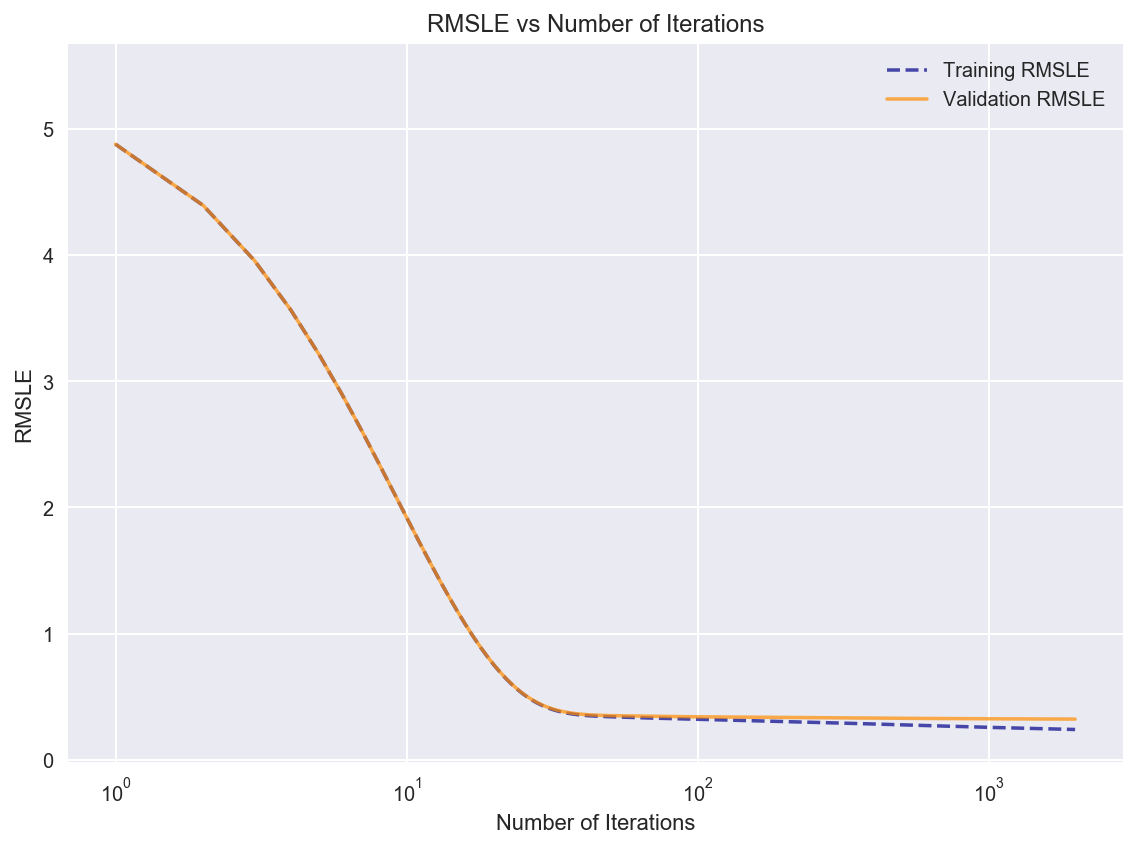

In [49]:
plt.figure(figsize=(8, 6))
plt.semilogx(regressor_xgb.evals_result_['validation_0']['rmse'], label='Training RMSLE',
             ls='dashed', alpha=.7, c='darkblue')
plt.semilogx(regressor_xgb.evals_result_['validation_1']['rmse'], label='Validation RMSLE',
             alpha=.7, c='darkorange')
plt.title('RMSLE vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSLE')
plt.legend()
plt.tight_layout()

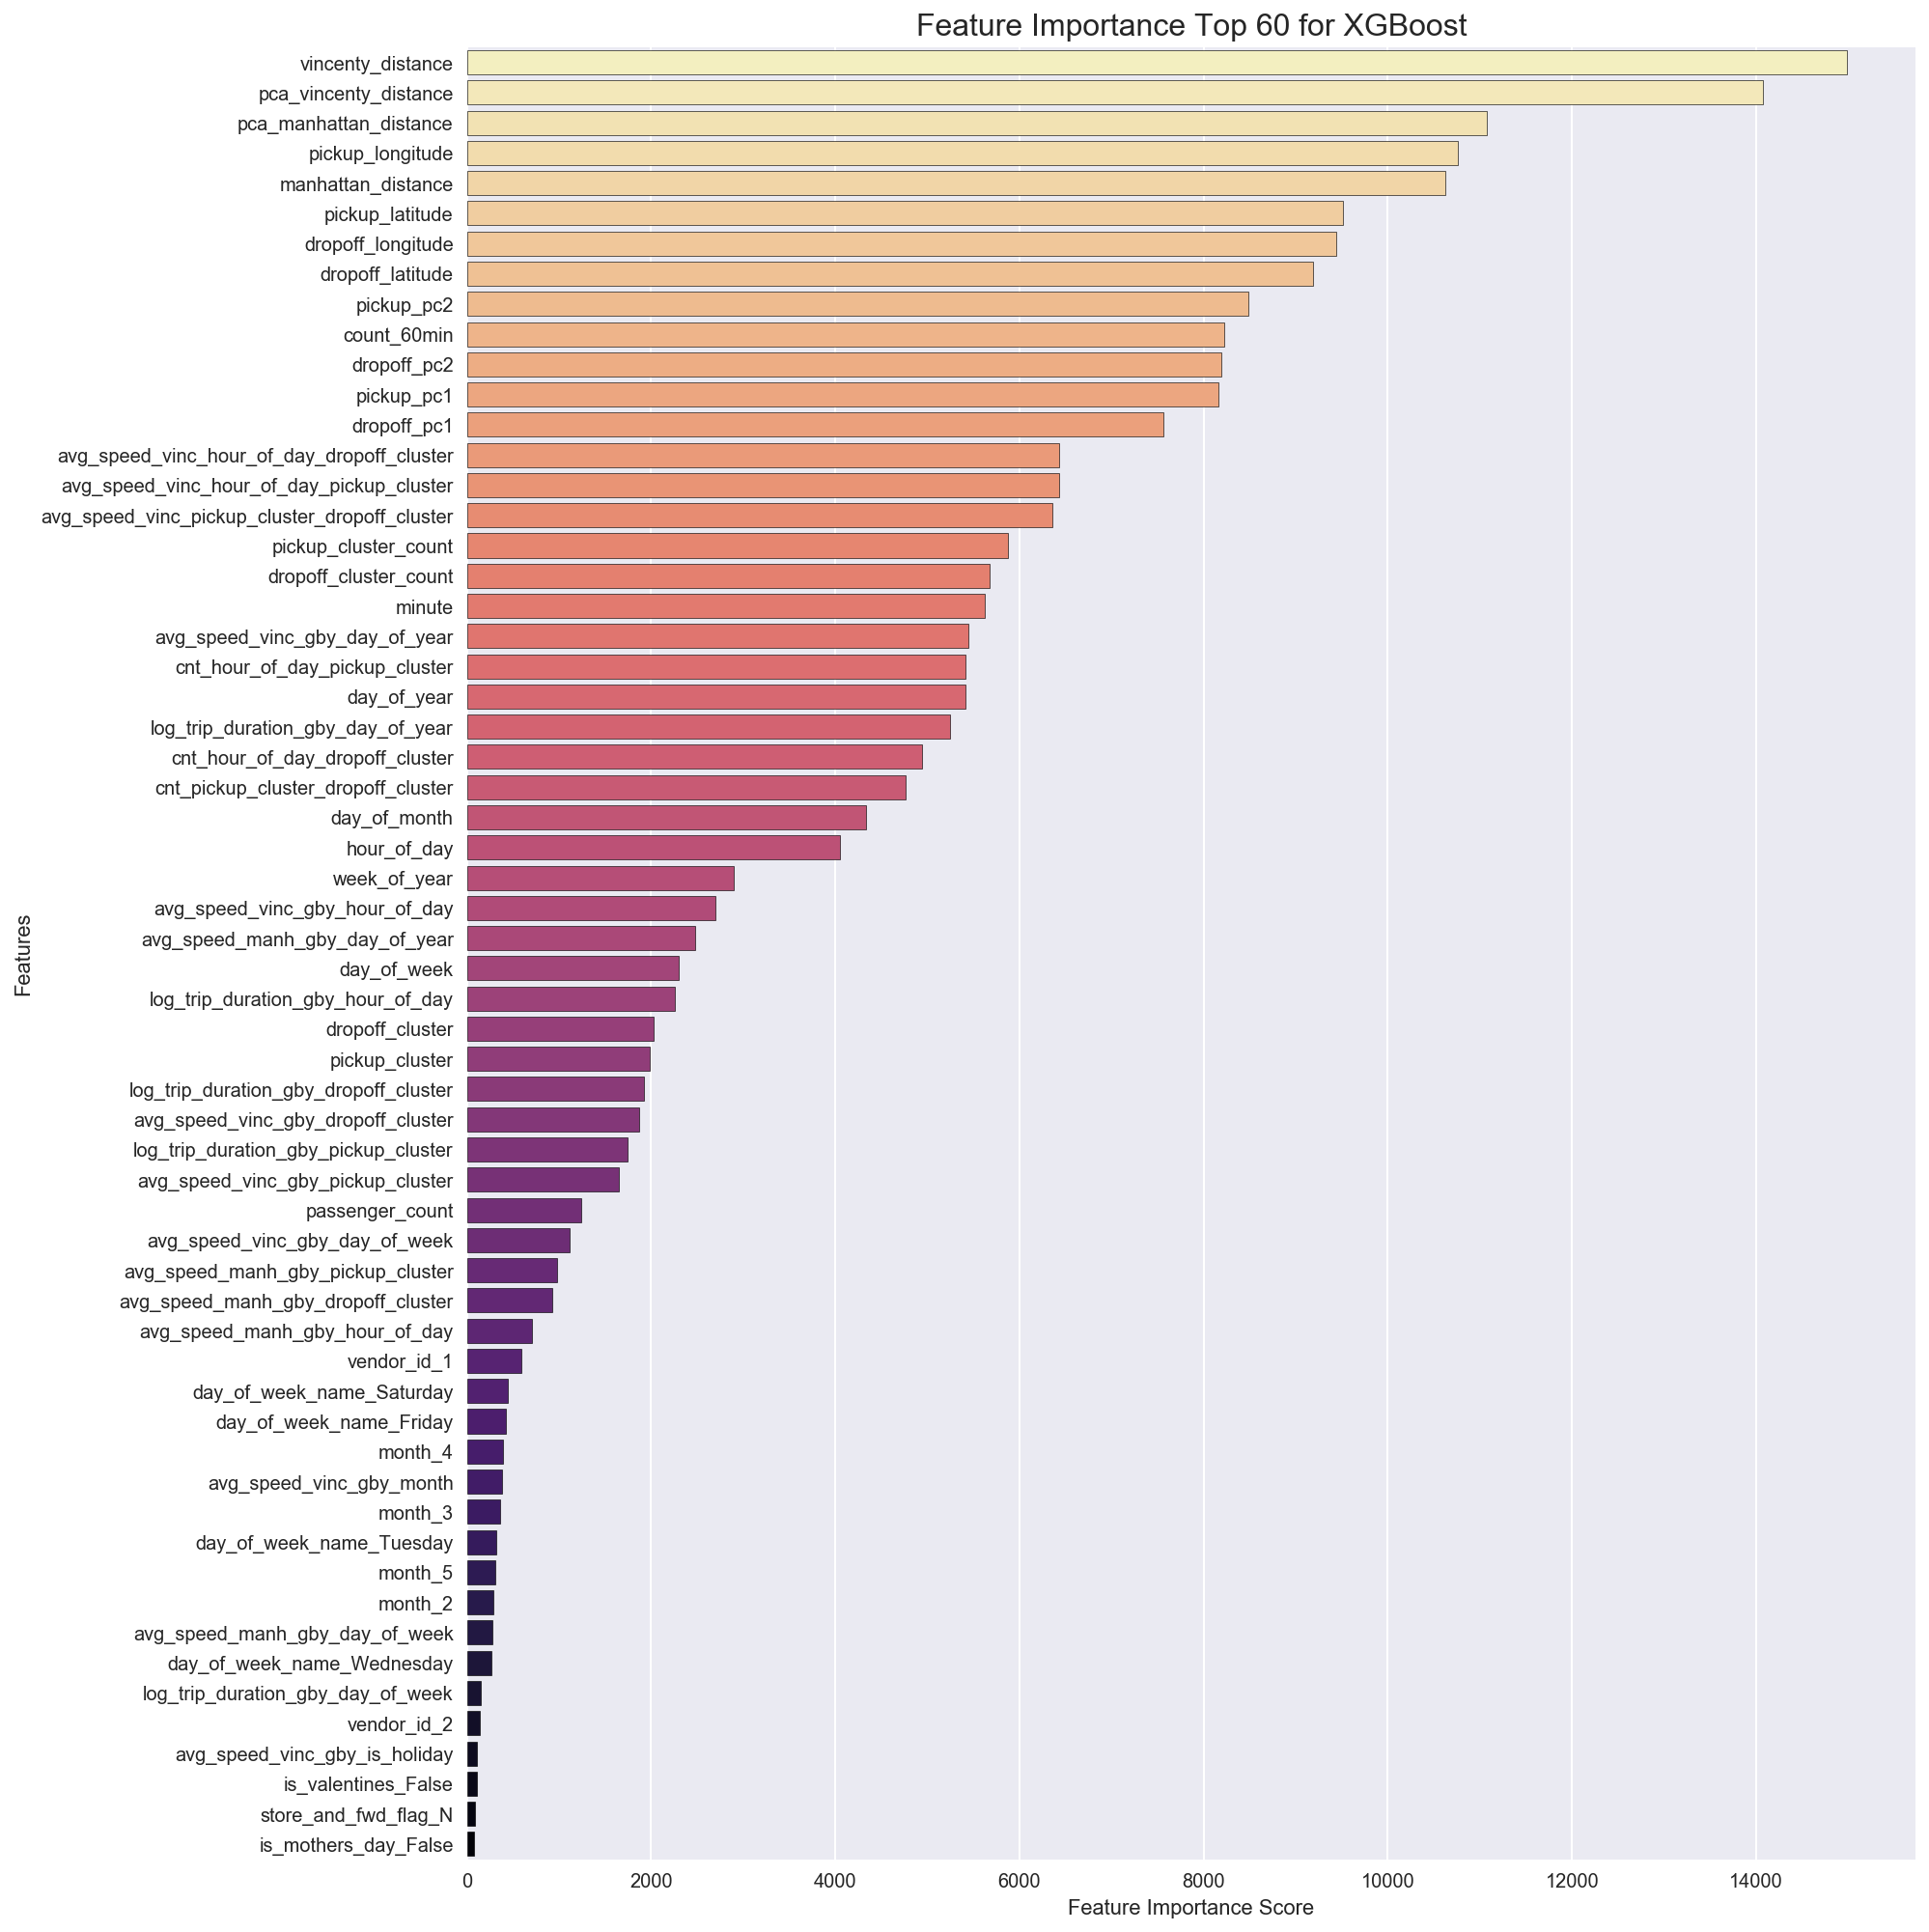

In [50]:
# Extract feature importances
import operator
num_features = 60
importances = regressor_xgb.booster().get_fscore()
features = sorted(importances.items(), key=operator.itemgetter(1), reverse=True)[:num_features]
feat, imp = zip(*features)
feat = list(feat); imp = list(imp)
for i, f in enumerate(feat):
    feat[i] = final_train_df.columns.values[int(f[1:])]

# Plot feature importances
plt.figure(figsize=(14, 14))
sns.barplot(x=imp, y=feat, estimator=np.sum, palette='magma_r')
plt.title('Feature Importance Top {} for XGBoost'.format(num_features), fontsize=16)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()

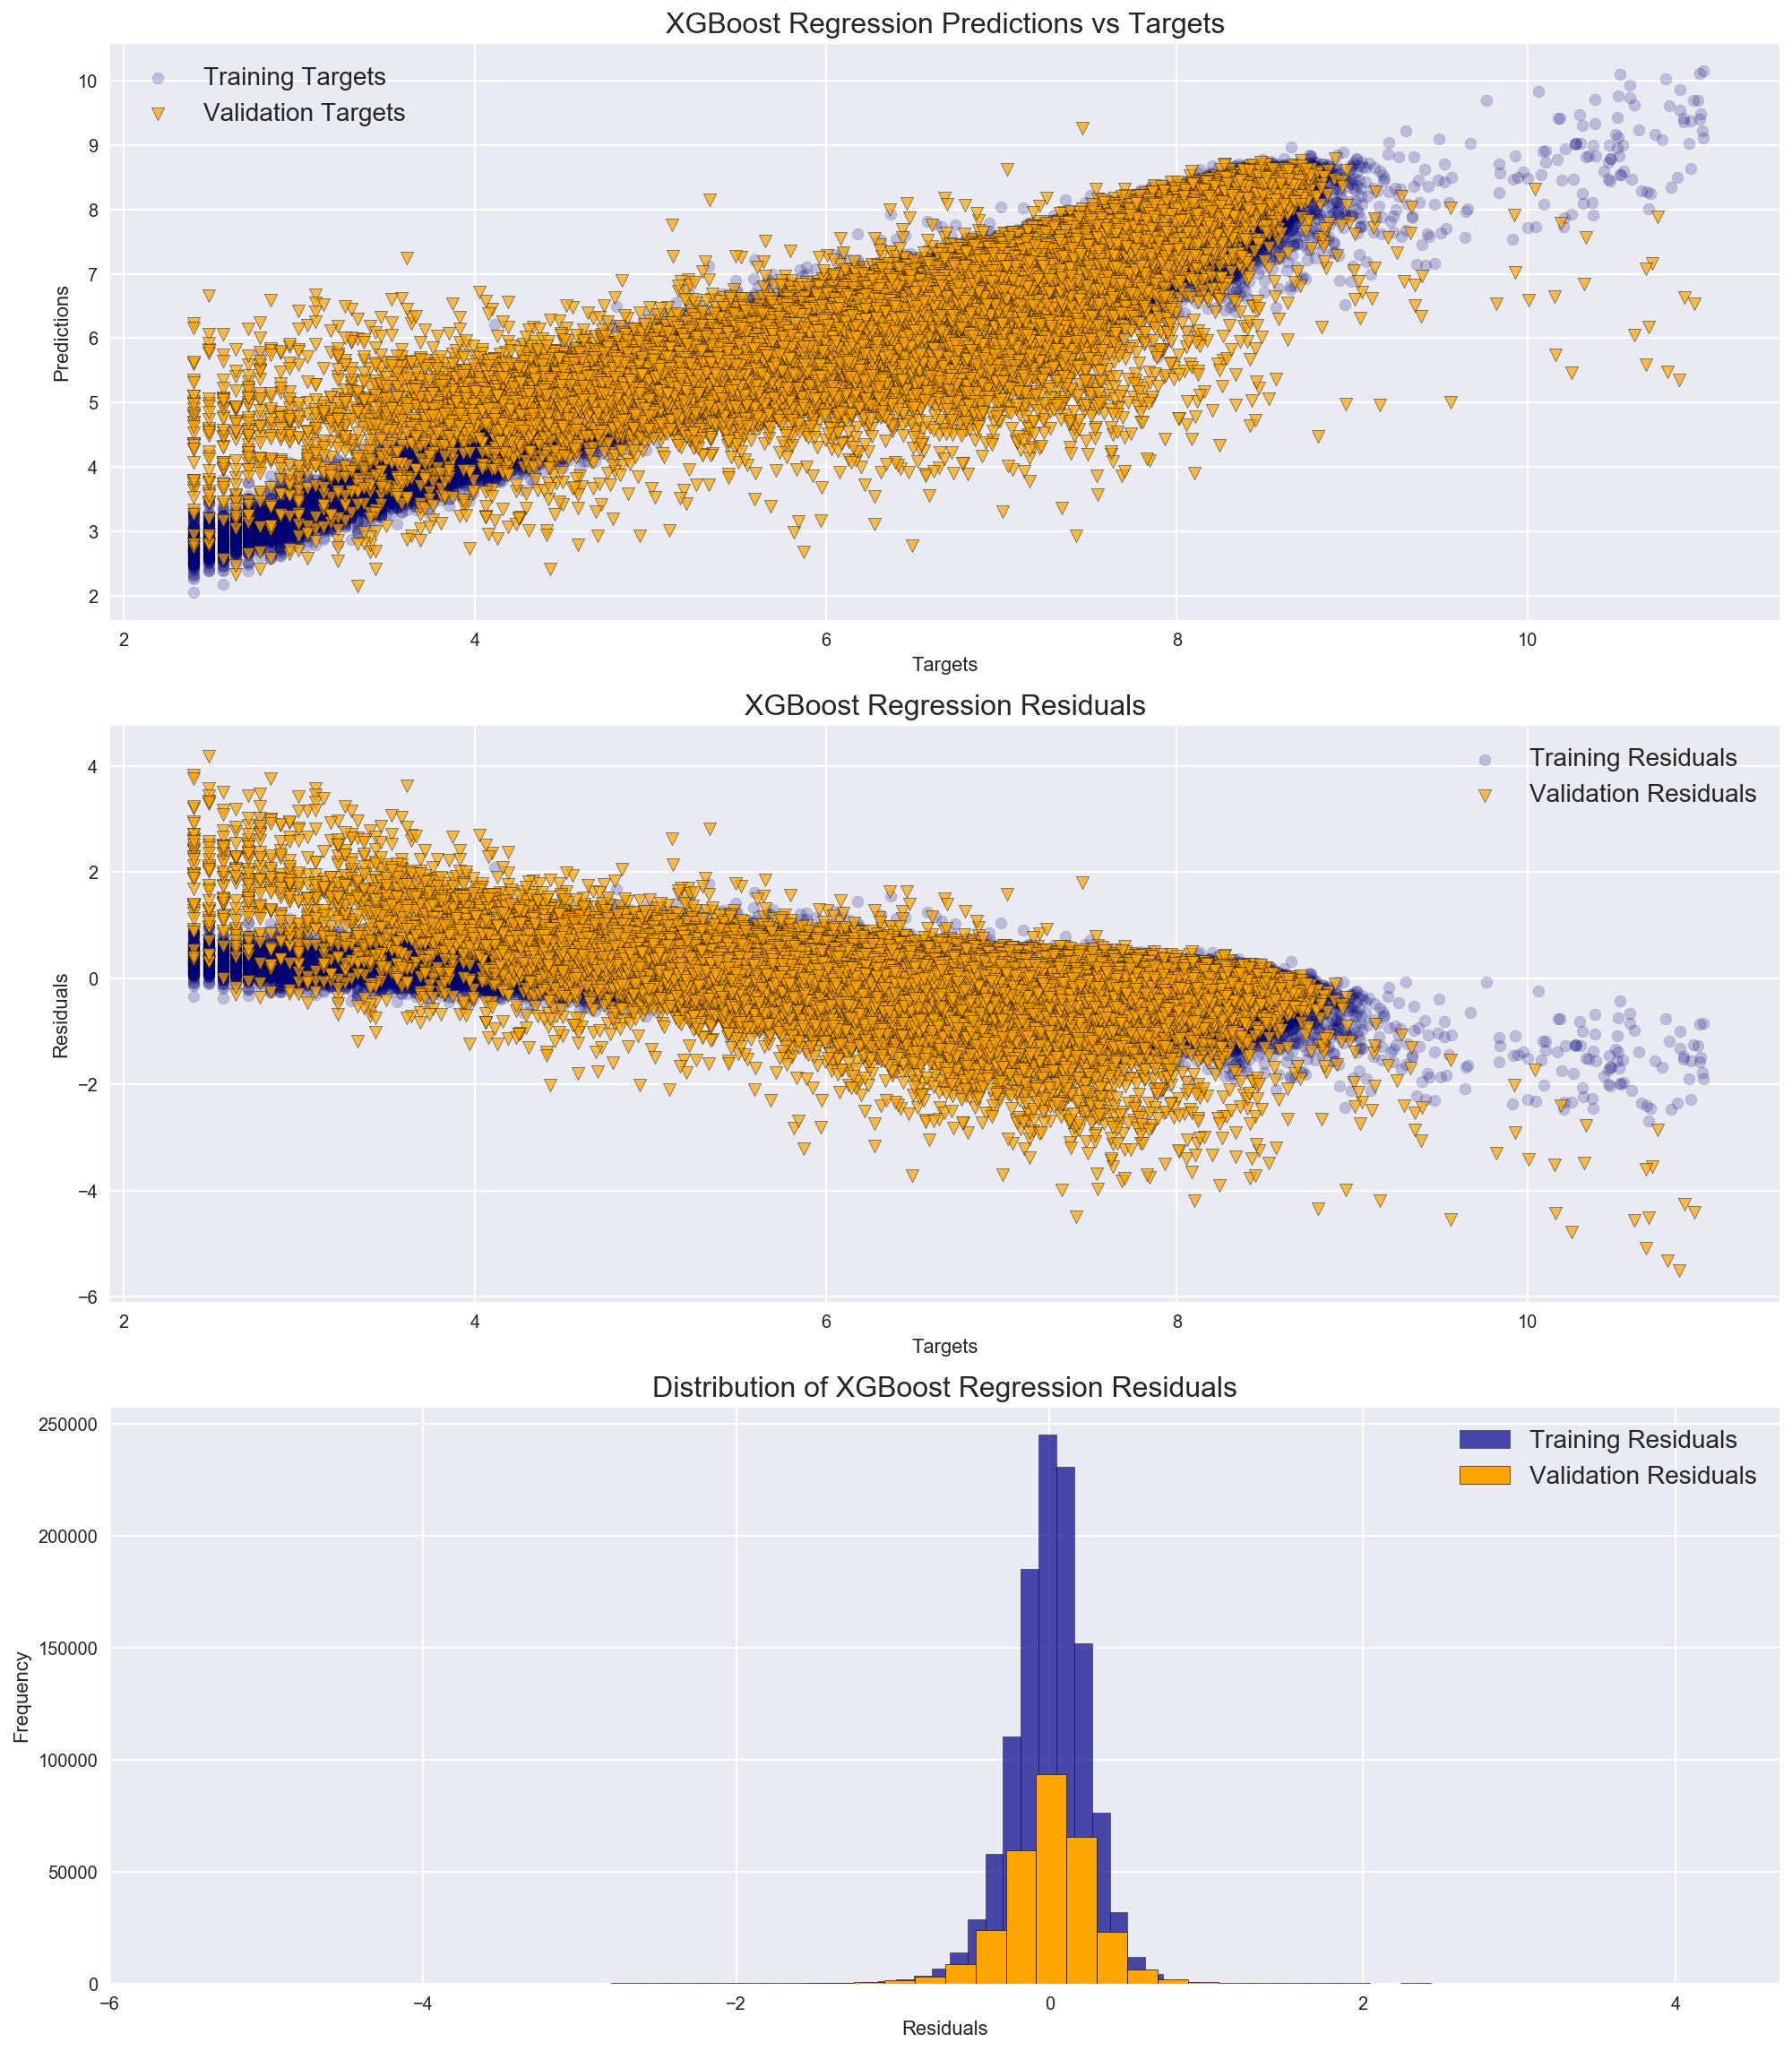

In [51]:
# Calculate residuals
res_train = pred_xgb_tr - y_train
res_val = pred_xgb_val - y_val

# Plot predictions vs targets
plt.figure(figsize=(14, 16))
plt.subplot(311)
plt.scatter(y_train, pred_xgb_tr, label='Training Targets',
            s=40, c='darkblue', edgecolors='black', alpha=.2)
plt.scatter(y_val, pred_xgb_val, label='Validation Targets',
            s=50, c='orange', edgecolors='black', alpha=.7, marker='v')
plt.title('XGBoost Regression Predictions vs Targets', fontsize=16)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend(fontsize=14)

# Plot residuals
plt.subplot(312)
plt.scatter(y_train, res_train, label='Training Residuals', 
            s=40, c='darkblue', edgecolors='black', alpha=.2)
plt.scatter(y_val, res_val, label='Validation Residuals',
            s=50, c='orange', edgecolors='black', alpha=.7, marker='v')
plt.title('XGBoost Regression Residuals', fontsize=16)
plt.xlabel('Targets')
plt.ylabel('Residuals')
plt.legend(fontsize=14)

# Plot residuals distribution
plt.subplot(313)
plt.hist(res_train, bins=50, color='darkblue', label='Training Residuals',alpha=.7)
plt.hist(res_val, bins=50, color='orange', label='Validation Residuals')
plt.title('Distribution of XGBoost Regression Residuals', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend(fontsize=14)

plt.tight_layout()

In [52]:
pred_xgb_test = np.round(np.expm1(regressor_xgb.predict(X_test))).astype(int)
pred_xgb_test

array([ 766,  647,  424, ..., 1605, 1992, 1081])

In [53]:
submission = pd.DataFrame({'id': test_df.id,
                           'trip_duration': pred_xgb_test})
submission.to_csv("submission.csv", index=False)

In [55]:
pred_xgb_test.mean()

807.337468446765

In [ ]:
# Check relation of short durations with distance!